## 1. Загрузка данных

В одном логе содержится информация о четырех прогонах. 

В каждом прогоне последовательно предоставляются 28 стимулов, для каждого из которых выделяется 3 скана: пауза, показ, ответ. 

Итого имеет по 84 скана на каждый прогон. 

По 3 на каждый стимул. 

По 4 четыре прогона на каждый из двух типов датасетов(friends, strangers). 

In [1]:
import pandas as pd
#import mne
import copy
import time
import math
import numpy as np
import numpy.ma as ma
import os
import sys
import shutil
import multiprocessing
from multiprocessing import Process, Queue, Pool
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib # common way of importing nibabel
from nilearn.image import resample_img
from nilearn.masking import compute_brain_mask
from scipy.ndimage import zoom
import scipy.optimize as scopt
import numpy as np
import scipy
from scipy.optimize import LinearConstraint
from scipy import interpolate
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import svd, pinv
from scipy.optimize import SR1
from scipy import integrate
import concurrent.futures
from typing import List, Dict, Tuple
import pickle
from diploma_functions import get_X, load_patient_data, chunk_voxels, run_computing_on_chunk,\
computing, get_best_thresholds, get_reproducibility, get_map_array, plot_map
from diploma_functions import is_serializable, total_size, coord_voxel, f_obj, get_thresholds_dict, get_t_groups, \
voxel_coord, coord_voxel, load_patient_logs, print_matrix, print_vector, get_Y, NpEncoder

In [2]:
def merge_fmri_scans(input_dir, output_file, file_pattern="*.nii"):
    """
    Объединяет 3D NIfTI-файлы в один 4D-файл.

    Параметры:
    - input_dir: Папка с исходными файлами.
    - output_file: Путь для сохранения 4D-файла (например, "merged_fmri.nii").
    - file_pattern: Шаблон имен файлов (например, "sub-01_*.nii").
    """
    # Получаем список файлов, сортируем по именам
    files = sorted([f for f in os.listdir(input_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    if not files:
        raise ValueError("NIfTI-файлы не найдены!")

    # Загружаем первый файл для получения заголовка и affine-матрицы
    first_scan = nib.load(os.path.join(input_dir, files[0]))
    header = first_scan.header.copy()
    affine = first_scan.affine

    # Собираем все данные в массив numpy
    all_volumes = []
    for file in files:
        scan = nib.load(os.path.join(input_dir, file))
        all_volumes.append(scan.get_fdata())

    # Объединяем вдоль временной оси (4D)
    merged_data = np.stack(all_volumes, axis=-1)

    # Создаем новый 4D NIfTI-файл
    new_img = nib.Nifti1Image(merged_data, affine, header)
    nib.save(new_img, output_file)
    print(f"Сохранено: {output_file} (формат: {merged_data.shape})")



In [3]:
def make_log(patient_logs_path):
    new_logs_dict = {}
    logs_dict = load_patient_logs(patient_logs_path)
    for run in logs_dict.keys():
        logs_dict[run] = logs_dict[run].loc[(logs_dict[run].index % 2 == 0) & \
        (logs_dict[run].index != 0) & (logs_dict[run].index != len(logs_dict) - 1)]
        logs_dict[run] = logs_dict[run].reset_index(drop=True)

    for run in logs_dict.keys():
        data = {}
        data['Onset'] = (logs_dict[run]['values.PreStimInterval']/1000 + 10 * logs_dict[run].index + 10)
        data['Duration'] = np.array([2.5 for i in range(len(logs_dict[run]))])
        data['Condition'] = logs_dict[run]['stimulusitem1']
        new_logs_dict[run] = pd.DataFrame(data=data)
        #display(new_logs_dict[run].head(5))
    
    #for run in logs_dict.keys():
    #    #display(logs_dict[run].head(5))
    return new_logs_dict

In [4]:
def copy_struct(patient_data_path, new_patient_path, patient):
    patient_struc_path = os.path.join(patient_data_path, 'structural')
    list_dir = os.listdir(path=patient_struc_path)
    scan = nib.load(os.path.join(patient_struc_path, list_dir[0]))
    nib.save(scan, os.path.join(new_patient_path, patient, 'anat', 'T1.nii'))

In [5]:
def make_data_for_SPM(patient_data_path, patient_logs_path, patient, new_patient_path, runs):
    logs_dict = make_log(patient_logs_path)
    if not os.path.exists(os.path.join(new_patient_path, patient)):
        os.mkdir(os.path.join(new_patient_path, patient))

    if not os.path.exists(os.path.join(new_patient_path, patient, 'func')):
        os.mkdir(os.path.join(new_patient_path, patient, 'func'))

    if not os.path.exists(os.path.join(new_patient_path, patient, 'events')):
        os.mkdir(os.path.join(new_patient_path, patient, 'events'))

    if not os.path.exists(os.path.join(new_patient_path, patient, 'anat')):
        os.mkdir(os.path.join(new_patient_path, patient, 'anat'))
        
    for i, run in enumerate(runs):
        merge_fmri_scans(
                input_dir=os.path.join(patient_data_path, run), 
                output_file=os.path.join(new_patient_path, patient, 'func', 'run' + '_' + run + '.nii') 
            )
    for i, run in enumerate(runs):
        logs_dict[run].to_csv(os.path.join(new_patient_path, patient, 'events', 'run' + '_' + run + '.csv'), index=False)

    copy_struct(patient_data_path, new_patient_path, patient)

In [7]:
patients = ['M_Y3_003', 'M_Y3_007', 'M_Y3_012', 'M_Y3_019', 'M_Y3_024', 'M_Y3_025', \
               'M_Y3_040', 'M_Y3_042', 'M_Y3_046', 'M_Y3_057']
subs = ['sub-03', 'sub-07', 'sub-12', 'sub-19', 'sub-24', 'sub-25', 'sub-40', 'sub-42', 'sub-46', 'sub-57']
runs = ['me_1', 'me_2', 'me_3', 'fr_1', 'fr_2', 'fr_3']
new_patient_path = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM'
patient = patients[0]
run = runs[0]
patient_data_folder = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные'
patient_logs_folder = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные'
for i in range(len(patients)):
    patient = patients[i]
    sub = subs[i]
    patient_data_path = os.path.join(patient_data_folder, patient)
    patient_logs_path = os.path.join(patient_logs_folder, patient, 'log')
    make_data_for_SPM(patient_data_path, patient_logs_path, sub, new_patient_path, runs)

Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-03\func\run_me_1.nii (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-03\func\run_me_2.nii (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-03\func\run_me_3.nii (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-03\func\run_fr_1.nii (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-03\func\run_fr_2.nii (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-03\func\run_fr_3.nii (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-07\func\run_me_1.nii (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\sub-07\func\run_me_2.nii (формат: (112, 112, 25, 148))


In [7]:
for patient in ['M_Y3_004', 'M_Y3_007', 'M_Y3_012', 'M_Y3_019', 'M_Y3_024', 'M_Y3_025', \
               'M_Y3_040', 'M_Y3_042', 'M_Y3_046', 'M_Y3_057']:
    for run in ['me_1', 'me_2', 'me_3', 'fr_1', 'fr_2', 'fr_3']:
        input_dir = os.path.join(r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные', patient, run)
        output_file = os.path.join(r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM', patient, 'sub-01_task-faces_bold_' + run + '.nii.')
        if not os.path.exists(os.path.dirname(output_file)):
            os.mkdir(os.path.dirname(output_file))
                                              
                       
        
        merge_fmri_scans(
            input_dir=input_dir, 
            output_file=output_file
        )

Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\M_Y3_001\sub-01_task-faces_bold_me_1.nii. (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\M_Y3_001\sub-01_task-faces_bold_me_2.nii. (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\M_Y3_001\sub-01_task-faces_bold_me_3.nii. (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\M_Y3_001\sub-01_task-faces_bold_fr_1.nii. (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\M_Y3_001\sub-01_task-faces_bold_fr_2.nii. (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\M_Y3_001\sub-01_task-faces_bold_fr_3.nii. (формат: (112, 112, 25, 148))
Сохранено: C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\SPM\M_Y3_007\sub-01_task-faces_bold_me_1.nii. (формат: (112, 112, 25, 148))
Сохран

In [9]:
file_path = r"C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\M_Y3_007\fr_1\M_Y3_007_EPI_2_5_148_fr_1_001.nii"
file = nib.load(file_path)
print(file.header["pixdim"][1:4])

[1.9642857 1.9642857 4.999782 ]


In [ ]:
path = 'C:/Users/andrew/Desktop/Mag Diploma/Код и новые данные/'
df = pd.read_csv(path, sep='\t')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

In [2]:
path = 'C:/Users/andrew/Desktop/Mag Diploma/Код и новые данные/FRIEND-FaceMorphing24Slider-v3-fMRI-withEEG.iqx'
df = pd.read_csv(path, sep='\t')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 67, saw 5


In [8]:
path = r'C:\Users\andrew\Desktop\Mag Diploma\Code_and_new_data\data_preprocessed\M_Y3_003\structural\wmM_Y3_003_T1.nii'
file = nib.load(path)
header = file.header

print(header)
print(header.get_dim_info())
print(header.get_slice_duration())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 157 189 105   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.   1.   1.5  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'Warped')
aux_file        : np.bytes_(b'')
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 78.0
qoffset_y       : -

HeaderDataError: Slice dimension must be set for duration to be valid

C:\Users\andrew\Desktop\Mag Diploma\Code_and_new_data\data_preprocessed\M_Y3_003\fr_1\swarM_Y3_003_EPI_2_5_148_fr_1_139.nii
[[2.51428574 4.19047624 3.35238099 ... 0.         0.83809525 0.83809525]
 [2.51428574 5.02857149 4.19047624 ... 0.83809525 0.83809525 0.83809525]
 [2.51428574 4.19047624 3.35238099 ... 0.83809525 0.83809525 0.83809525]
 ...
 [0.83809525 0.83809525 1.6761905  ... 0.83809525 0.83809525 0.83809525]
 [0.83809525 0.83809525 0.83809525 ... 0.83809525 0.83809525 0.83809525]
 [0.83809525 0.83809525 0.83809525 ... 0.83809525 0.83809525 0.83809525]]
(53, 63)


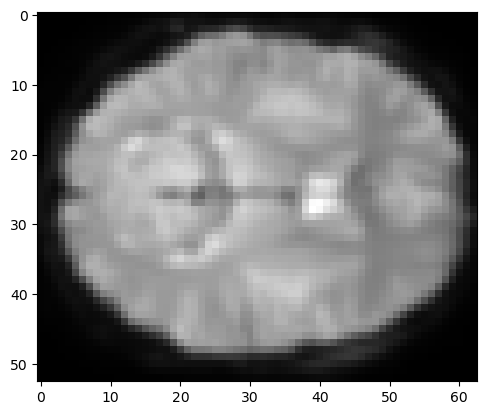

[[0.         0.         0.         ... 0.83809525 0.         0.        ]
 [0.         0.         0.         ... 0.83809525 0.         0.        ]
 [0.         0.         0.         ... 1.6761905  0.83809525 0.        ]
 ...
 [0.         0.         0.         ... 5.02857149 3.35238099 2.51428574]
 [0.         0.         0.         ... 4.19047624 4.19047624 2.51428574]
 [0.         0.         0.         ... 5.02857149 5.02857149 2.51428574]]
(53, 52)


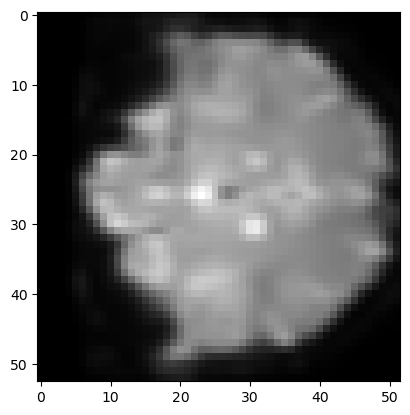

[[ 70.40000081  72.07619131  74.59047705 ...   0.           0.
    0.        ]
 [169.29524004 176.83809727 183.54285926 ...   0.           0.
    0.        ]
 [253.10476482 263.16190779 283.27619374 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   2.51428574   2.51428574
    2.51428574]
 [  0.           0.           0.         ...   2.51428574   3.35238099
    3.35238099]
 [  0.           0.           0.         ...   1.6761905    2.51428574
    2.51428574]]
(63, 52)


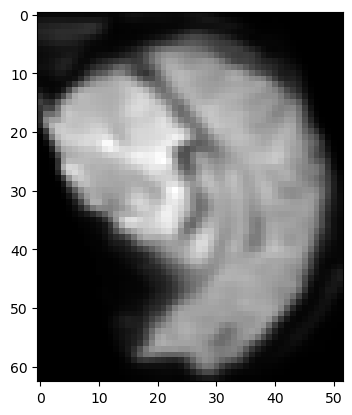

In [3]:
path = r'C:\Users\andrew\Desktop\Mag Diploma\Code_and_new_data\data_preprocessed\M_Y3_003\fr_1\swarM_Y3_003_EPI_2_5_148_fr_1_139.nii'
print(path)
mask_file = nib.load(path)
data = mask_file.get_fdata()
data_shape = data.shape

data1 = data[:, :, data_shape[2]//2]
print(data1)
print(data1.shape)
plt.imshow(data1, cmap='gray')
plt.show()

data2 = data[:, data_shape[1]//2, :]
print(data2)
print(data2.shape)
plt.imshow(data2, cmap='gray')
plt.show()

data3 = data[data_shape[2]//2, :, :]
print(data3)
print(data3.shape)
plt.imshow(data3, cmap='gray')
plt.show()

---------------------- C:\Users\andrew\Desktop\Mag Diploma\Code_and_new_data\data_preprocessed\M_Y3_003\fr_1\swarM_Y3_003_EPI_2_5_148_fr_1_001.nii ------------------------------
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [ 3 53 63 52  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'Warped - conv(4,4,4)')
aux_file        : 

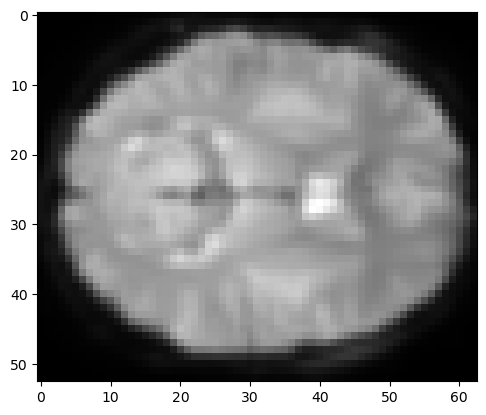

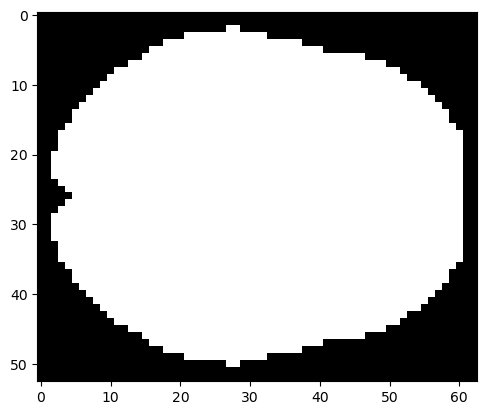

[[0.         0.         0.         ... 0.83809525 0.         0.        ]
 [0.         0.         0.         ... 0.83809525 0.         0.        ]
 [0.         0.         0.         ... 1.6761905  0.83809525 0.        ]
 ...
 [0.         0.         0.         ... 5.02857149 3.35238099 2.51428574]
 [0.         0.         0.         ... 4.19047624 4.19047624 2.51428574]
 [0.         0.         0.         ... 5.02857149 5.02857149 2.51428574]]
(53, 52)


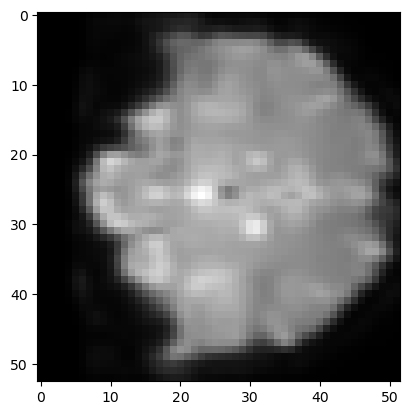

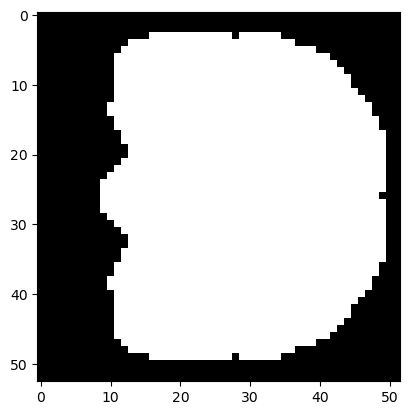

[[ 70.40000081  72.07619131  74.59047705 ...   0.           0.
    0.        ]
 [169.29524004 176.83809727 183.54285926 ...   0.           0.
    0.        ]
 [253.10476482 263.16190779 283.27619374 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   2.51428574   2.51428574
    2.51428574]
 [  0.           0.           0.         ...   2.51428574   3.35238099
    3.35238099]
 [  0.           0.           0.         ...   1.6761905    2.51428574
    2.51428574]]
(63, 52)


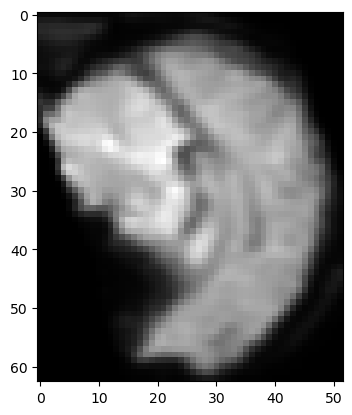

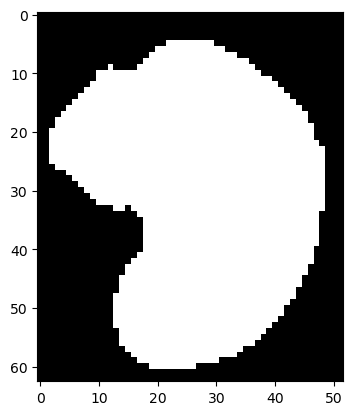

In [6]:
path = r'C:\Users\andrew\Desktop\Mag Diploma\Code_and_new_data\data_preprocessed\M_Y3_003\fr_1\swarM_Y3_003_EPI_2_5_148_fr_1_001.nii'
#files = os.listdir(path)
#files = [file for file in files if 'wm' in file]
files = []
files.append(path)
target_shape = (53, 63, 52)
for file in files:
    if file.split('.')[1] != 'nii':
        continue
    print('----------------------', file, '------------------------------')
    file_path = os.path.join(path, file)
    nib_file = nib.load(file_path)
    img = nib_file
    data = img.get_fdata()
    max_data = np.max(data)
    threshold = 0.1 * max_data
    brain_mask = compute_brain_mask(img, threshold=0.1)
    mask_data = brain_mask.get_fdata()
    bm1 = mask_data[:, :, data_shape[2]//2]
    bm2 = mask_data[:, data_shape[1]//2, :]
    bm3 = mask_data[data_shape[0]//2, :, :]
    
    old_shape = data.shape  # (157, 189, 105)
    new_shape = (53, 63, 52)
    zoom_factors = [n/o for n, o in zip(new_shape, old_shape)]
    
    # Масштабируем данные
    resampled_data = zoom(data, zoom_factors, order=3)  # order=3 — бикубическая интерполяция
    #data = resampled_data
    
    header = nib_file.header
    
    print(header)
    data_shape = data.shape
    #print(header.get_dim_info())
    #print(header.get_slice_duration())
    print(data1)
    data1 = data[:, :, data_shape[2]//2]
    print(data1.shape)
    plt.imshow(data1, cmap='gray')
    plt.show()

    plt.imshow(bm1, cmap='gray')
    plt.show()

    
    #m1 = ma.masked_where(data1>50, data1)
    #plt.imshow(m1, cmap='gray')
    #plt.show()
            
    print(data2)
    data2 = data[:, data_shape[1]//2, :]
    print(data2.shape)
    plt.imshow(data2, cmap='gray')
    plt.show()

    plt.imshow(bm2, cmap='gray')
    plt.show()

    #m2 = ma.masked_where(data2>50, data2)
    #plt.imshow(m2, cmap='gray')
    #plt.show()

    print(data3)
    data3 = data[data_shape[0]//2, :, :]
    print(data3.shape)
    plt.imshow(data3, cmap='gray')
    plt.show()

    plt.imshow(bm3, cmap='gray')
    plt.show()

    #m3 = ma.masked_where(data3>50, data3)
    #plt.imshow(m3, cmap='gray')
    #plt.show()

---------------------- wmM_Y3_003_T1.nii ------------------------------
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 157 189 105   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.   1.   1.5  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'Warped')
aux_file        : np.bytes_(b'')
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c     

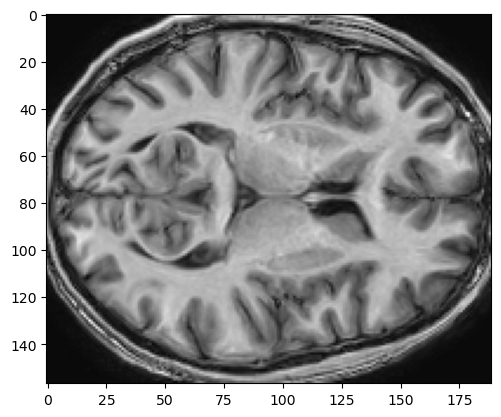

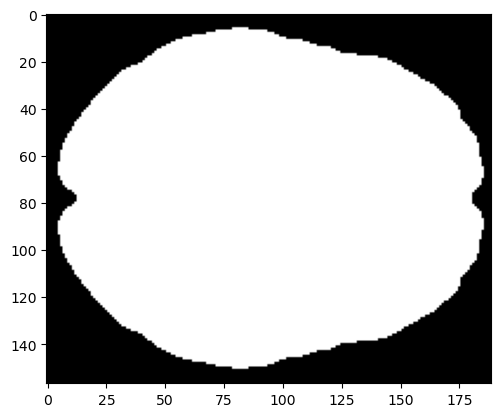

[[ 1.09965019e+02  1.03422447e+02  1.30333817e+02 ... -1.21508037e-05
   3.08352651e-06 -1.63742769e-07]
 [ 2.29083893e+02  2.40667999e+02  4.57219940e+02 ...  1.99768619e-05
  -3.59594719e-06 -1.54404162e-07]
 [ 3.52967072e+02  6.15241211e+02  8.15921509e+02 ...  8.93126798e-06
  -1.59048966e-06  2.07297290e-07]
 ...
 [ 9.92951508e+01  8.29461136e+01  1.51589890e+02 ... -1.33598244e+00
   1.38623893e-01 -1.24039218e-01]
 [ 7.22766418e+01  6.66764297e+01  7.19211121e+01 ...  7.26902151e+00
  -6.72276855e-01  2.85885811e-01]
 [ 1.00349487e+02  8.29589996e+01  4.69751091e+01 ...  1.58956976e+01
  -1.94923389e+00  2.07744575e+00]]
(157, 105)


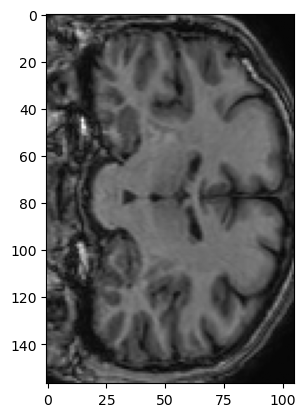

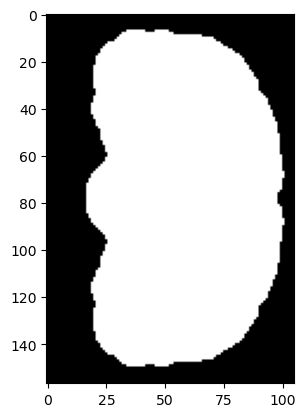

[[ 6.73304138e+01  4.93870354e+01  5.60950890e+01 ... -1.35680011e-05
  -2.11326187e-05  2.83823174e-04]
 [ 1.87358429e+02  2.25813553e+02  2.25206985e+02 ...  2.47029893e-05
   1.56376937e-05 -2.40644935e-04]
 [ 8.30953918e+02  7.65159180e+02  7.39799500e+02 ... -8.36749896e-05
  -2.60102588e-05  1.33917623e-04]
 ...
 [ 1.34191174e+03  1.07517822e+03  8.66288391e+02 ... -2.89317649e-02
  -7.43656680e-02  6.27376020e-01]
 [ 1.38753650e+03  1.12880713e+03  9.13984436e+02 ...  5.54451235e-02
   2.36812249e-01 -2.04690194e+00]
 [ 1.24691223e+03  1.10195081e+03  1.15337903e+03 ...  1.44168481e-01
  -1.68785739e+00  1.10095882e+01]]
(189, 105)


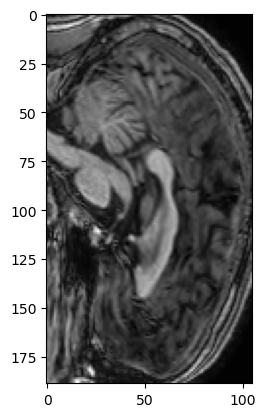

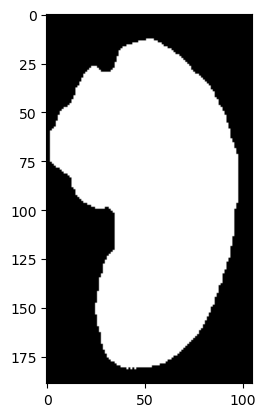

In [14]:
path = r'C:\Users\andrew\Desktop\Mag Diploma\Code_and_new_data\data_preprocessed\M_Y3_003\structural'
files = os.listdir(path)
files = [file for file in files if 'wm' in file]
target_shape = (53, 63, 52)
for file in files:
    if file.split('.')[1] != 'nii':
        continue
    print('----------------------', file, '------------------------------')
    file_path = os.path.join(path, file)
    nib_file = nib.load(file_path)
    img = nib_file
    data = img.get_fdata()
    max_data = np.max(data)
    threshold = 0.1 * max_data
    brain_mask = compute_brain_mask(img, threshold=0.1)
    mask_data = brain_mask.get_fdata()
    bm1 = mask_data[:, :, data_shape[2]//2]
    bm2 = mask_data[:, data_shape[1]//2, :]
    bm3 = mask_data[data_shape[0]//2, :, :]
    
    old_shape = data.shape  # (157, 189, 105)
    new_shape = (53, 63, 52)
    zoom_factors = [n/o for n, o in zip(new_shape, old_shape)]
    
    # Масштабируем данные
    resampled_data = zoom(data, zoom_factors, order=3)  # order=3 — бикубическая интерполяция
    #data = resampled_data
    
    header = nib_file.header
    
    print(header)
    data_shape = data.shape
    #print(header.get_dim_info())
    #print(header.get_slice_duration())
    print(data1)
    data1 = data[:, :, data_shape[2]//2]
    print(data1.shape)
    plt.imshow(data1, cmap='gray')
    plt.show()

    plt.imshow(bm1, cmap='gray')
    plt.show()

    
    #m1 = ma.masked_where(data1>50, data1)
    #plt.imshow(m1, cmap='gray')
    #plt.show()
            
    print(data2)
    data2 = data[:, data_shape[1]//2, :]
    print(data2.shape)
    plt.imshow(data2, cmap='gray')
    plt.show()

    plt.imshow(bm2, cmap='gray')
    plt.show()

    #m2 = ma.masked_where(data2>50, data2)
    #plt.imshow(m2, cmap='gray')
    #plt.show()

    print(data3)
    data3 = data[data_shape[0]//2, :, :]
    print(data3.shape)
    plt.imshow(data3, cmap='gray')
    plt.show()

    plt.imshow(bm3, cmap='gray')
    plt.show()

    #m3 = ma.masked_where(data3>50, data3)
    #plt.imshow(m3, cmap='gray')
    #plt.show()

In [5]:
patients = ['M_Y3_012', 'M_Y3_019', 'M_Y3_024', 'M_Y3_025', \
               'M_Y3_040', 'M_Y3_042', 'M_Y3_046', 'M_Y3_057']
subs = ['sub-03', 'sub-07', 'sub-12', 'sub-19', 'sub-24', 'sub-25', 'sub-40', 'sub-42', 'sub-46', 'sub-57']
runs = ['me_1', 'me_2', 'me_3', 'fr_1', 'fr_2', 'fr_3']
patient_data_folder = r'C:\Users\andrew\Desktop\Mag Diploma\Code_and_new_data\data_preprocessed'
for i in range(len(patients)):
    patient = patients[i]
    sub = subs[i]
    patient_data_path = os.path.join(patient_data_folder, patient)
    fr_path = os.path.join(patient_data_path, 'Friend')
    me_path = os.path.join(patient_data_path, 'Me')
    fr_runs = os.listdir(fr_path)
    me_runs = os.listdir(me_path)
    for i in range(1, 4):
        fr_run_path = os.path.join(fr_path, 'run' + str(i))
        me_run_path = os.path.join(me_path, 'run' + str(i))
        new_fr_run_path = os.path.join(patient_data_path, 'fr_' + str(i))
        new_me_run_path = os.path.join(patient_data_path, 'me_' + str(i))
        #os.mkdir(new_fr_run_path)
        #os.mkdir(new_me_run_path)
        shutil.copytree(fr_run_path, new_fr_run_path)
        shutil.copytree(me_run_path, new_me_run_path)
        #shutil.rmtree(fr_run_path)
        #shutil.rmtree(me_run_path)
        fr_files = os.listdir(new_fr_run_path)
        me_files = os.listdir(new_me_run_path)
        for file in fr_files:
            if 'swar' not in file:
                file_path = os.path.join(new_fr_run_path, file)
                os.remove(file_path)
        for file in me_files:
            if 'swar' not in file:
                file_path = os.path.join(new_me_run_path, file)
                os.remove(file_path)
    shutil.rmtree(fr_path)
    shutil.rmtree(me_path)
            
        
        
    

In [22]:
path = 'C:/Users/andrew/Desktop/Mag Diploma/Код и новые данные/M_Y3_057/log/M_Y3_057_me.iqdat'
df = pd.read_csv(path, sep='\t')
df = df.rename(columns={'values.ResponseForSubj':'Response', 'values.MeMorphShare':'MeMorph', \
          'values.FrMorphShare':'FrMorph', 'values.StMorphShare':'StMorph', 'values.WaitedForSynchro':'WaitedForSynchro',\
          'values.PreStimInterval':'PreStimInterval'})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df.drop(columns=['date', 'time', 'values.TestBlockNum', 'trialnum', 'response']))

,blockcode,trialcode,values.TestTrialNum,stimulusitem1,Response,MeMorph,FrMorph,StMorph,WaitedForSynchro,PreStimInterval,latency
0,RecHand,WhatHand,0,"Укажите, в какой руке будет находиться пульт д...",0,0,0,0,0,0,1315
1,TrainingBlock,Training,0,MeFr_10.png,0,0,100,0,0,0,2500
2,TrainingBlock,MorphSlider,0,0,0,0,100,0,0,0,5000
3,TrainingBlock,Training,0,MeFr_00.png,0,100,0,0,0,0,2500
4,TrainingBlock,MorphSlider,0,0,100,100,0,0,0,0,5000
5,TrainingBlock,Training,0,MeSt_10.png,0,0,0,100,0,0,2500
6,TrainingBlock,MorphSlider,0,0,0,0,0,100,0,0,5000
7,TrainingBlock,Training,0,MeSt_00.png,0,100,0,0,0,0,2500
8,TrainingBlock,MorphSlider,0,0,90,100,0,0,0,0,5000
9,TrainingBlock,Training,0,MeSt_00.png,0,100,0,0,0,0,2500


In [3]:
path = 'C:/Users/andrew/Desktop/Mag Diploma/Код и новые данные/fMRI_logs/M_Y2_007/M_y2_007_fr.tsv'
df = pd.read_csv(path, sep='\t')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,date,time,hand,blockNum,trialNum,trialcode,similarity,response,selfRecog,latency,preStimInterval,offset,onset
0,52823,11:18:42,R,1,0,FirstFace,9,30,0,456,333,0.333,30.333
1,52823,11:18:42,R,1,1,Neut,7,30,0,485,100,7.600,37.600
2,52823,11:18:42,R,1,2,Sad,2,48,1,339,656,15.656,45.656
3,52823,11:18:42,R,1,3,Hap,3,48,1,385,1212,23.712,53.712
4,52823,11:18:42,R,1,4,Neut,6,30,0,624,934,30.934,60.934
5,52823,11:18:42,R,1,5,Hap,1,48,1,344,2046,39.546,69.546
6,52823,11:18:42,R,1,6,Sad,3,30,0,689,2324,47.324,77.324
7,52823,11:18:42,R,1,7,Neut,9,30,0,350,1490,53.990,83.990
8,52823,11:18:42,R,1,8,Sad,8,30,0,551,1768,61.768,91.768
9,52823,11:18:42,R,1,9,Scr,0,30,0,323,378,67.878,97.878


In [4]:
path = 'C:/Users/andrew/Desktop/Mag Diploma/Код и новые данные/fMRI_logs/M_Y2_007/M_y2_007_str.tsv'
df = pd.read_csv(path, sep='\t')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,date,time,hand,blockNum,trialNum,trialcode,similarity,response,selfRecog,latency,preStimInterval,offset,onset
0,52823,10:57:19,R,1,0,FirstFace,1,48,1,539,333,0.333,30.333
1,52823,10:57:19,R,1,1,Sad,8,30,0,692,1212,8.712,38.712
2,52823,10:57:19,R,1,2,Hap,2,48,1,566,656,15.656,45.656
3,52823,10:57:19,R,1,3,Neut,9,30,0,645,1768,24.268,54.268
4,52823,10:57:19,R,1,4,Sad,6,30,0,580,100,30.100,60.100
5,52823,10:57:19,R,1,5,Neut,6,30,0,528,2324,39.824,69.824
6,52823,10:57:19,R,1,6,Hap,3,48,1,522,378,45.378,75.378
7,52823,10:57:19,R,1,7,Neut,3,48,1,499,2046,54.546,84.546
8,52823,10:57:19,R,1,8,Sad,3,48,1,1019,934,60.934,90.934
9,52823,10:57:19,R,1,9,Hap,6,30,0,377,1490,68.990,98.990


Функция для создания файлов, содержащих векторы $Y$ для регрессии

Вроде по 8 Гб на одного пациента, 1.5 часа на одного пациента - долго.

В виде nii файлов по 800 Мб на одного человека. Мб лучше так и хранить.

Функция для создания отдельных файлом для прогонов каждого вокселя

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Пока не запускаем, очень долго записывается и слишком много весит
</div>


Пока не запускаем, очень долго записывается и слишком много весит

In [3]:
#get_voxel_info_files(r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\fMRI_data', \
#                     r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\Данные по вокселям')

date - дата

time - время

hand - рука, которой нажимались кнопки

blockNum - номер блока изображений(прогона)

trialcode - тип стимула

similarity - степень морфинга(смешиваем изображения себя и кого-то другого, от 0 до 10)

responce - код нажатой кнопки

selfRecog - его расшифровка(1-"Я", 0-"неЯ")

latency - время реакции, если response равен 0, то реакции не было, и таймер дошел до таймаута

preStimInterval - случайная задержка для данного стимула в мс

offset - момент предъявления стимула, в секундах от начала блока

onset - не нужно

In [4]:
display(df)

,date,time,hand,blockNum,trialNum,trialcode,similarity,response,selfRecog,latency,preStimInterval,offset,onset
0,50723,12:26:31,R,1,0,FirstFace,1,48,1,524,333,0.333,30.333
1,50723,12:26:31,R,1,1,Sad,2,48,1,871,1768,9.268,39.268
2,50723,12:26:31,R,1,2,Scr,0,30,0,460,934,15.934,45.934
3,50723,12:26:31,R,1,3,Hap,8,30,0,711,378,22.878,52.878
4,50723,12:26:31,R,1,4,Neut,8,30,0,766,1490,31.490,61.490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,50723,12:26:31,R,4,23,Hap,3,30,0,346,934,173.434,173.434
108,50723,12:26:31,R,4,24,Neut,1,30,0,339,1212,181.212,181.212
109,50723,12:26:31,R,4,25,Hap,9,48,1,552,378,187.878,187.878
110,50723,12:26:31,R,4,26,Sad,3,30,0,391,100,195.100,195.100


Функция, возвращающая данные о необходимом количестве пациентов

Вход: 
* Ссылка на папку с данными, при этом данные о каждом пациенте в отдельной папке, в самой папке - набор прогонов конкретного пациента, каждый прогон - набор сканов
* Число пациентов, функция загрузит данные о первых пациентах в алфавитном порядке

Выход:
* Словарь всех сканов, доступ к конкретному скану: пациент->прогон->номер скана

(Тут вроде были проблемы с памятью, её не хватало на хранение всего словаря в оперативке, м.б. нужно отдельно всё загружать и высчитавать на месте. То есть надо бы написать функцию для загрузки информации о конретном прогоне/скане)

In [5]:
def load_data(data_link, numb_patients):
    
    data_dict = {}
    os.chdir(data_link)
    list_dir = os.listdir()
    i = 0
    for directory in list_dir:
        if directory == 'M_y2_002': #пропускаем, вроде были проблемы
            continue
        if i >= numb_patients: #берём данные о первых пациентах
            break
        
        #Пациент
        patient = directory.split('_')[2:] #номер пациента
        if len(patient) == 1:
            patient = patient[0]
        else:
            patient = patient[0] + '_' + patient[1]
        patient_path = os.path.join(data_link, directory)
        os.chdir(patient_path)
        
        #Прогоны для одного пациента
        runs = os.listdir()
        for run in runs:
            #Конкретный прогон
            run_path = os.path.join(patient_path, run)
            
            #Проверка, что это одна из нужных папок папка 
            if run.find('.') == -1 and len(run.split('_')) > 1 \
            and run.split('_')[1].isnumeric():
                
                #Список сканов
                scans = os.listdir(path=run_path)
                for scan in scans:
                    
                    #Конкретный скан
                    scan_path = os.path.join(run_path, scan)
                    
                    #Проверка, что это действительно файл фМРТ
                    if scan.find('.nii') != -1:
                        if patient not in data_dict.keys():
                            data_dict[patient] = {}
                        if run not in data_dict[patient].keys():
                            data_dict[patient][run] = []
                        scan_img = nib.load(scan_path)
                        data_dict[patient][run].append(scan_img.get_fdata())
        i = i + 1
    return data_dict

Функция для загрузки конкретного скана

In [6]:
def load_scan_data(scan_data_path):
    
    patient_path = os.path.join(data_link, patient)
    run_path = os.path.join(patient_path, run)
    scan_path = os.path.join(run_path, scan)
    scan_img = nib.load(scan_path)
    return scan_img.get_fdata()

Фукнция для загрузки всех сканов из прогона

In [7]:
def load_run_data(run_data_path):
    scans_list = []
    
    scans = os.listdir(path=run_data_path)
    for scan in scans:
        #Конкретный скан
        scan_path = os.path.join(run_data_path, scan)
        
        #Проверка, что это действительно файл фМРТ
        if scan.find('.nii') != -1:
            scan_img = nib.load(scan_path)
            scans_list.append(scan_img.get_fdata())
    return scans_list

Функция для загрузки всех сканов из прогонов для конкретного пациента

Параметр mode отвечает за загрузку данных прогонов

mode = '+' означает, что данные по всем прогонам загрузятся раздельно

mode = 'fr' загрузит только fr

mode = 'str' загрузит только str

In [8]:
def load_patient_data(patient_data_path, mode='+'):
    patient_data_dict = {}

    os.chdir(patient_data_path)
    
    #Прогоны для одного пациента
    runs = os.listdir(path=patient_data_path)
    for run in runs:
        #Конкретный прогон
        run_path = os.path.join(patient_data_path, run)
        
        #Проверка, что это одна из нужных папок папка 
        if run.find('.') == -1 and len(run.split('_')) > 1 and run.split('_')[1].isnumeric():
            if mode == 'fr' and run.split('_')[0] == 'str':
                continue
            if mode == 'str' and run.split('_')[0] == 'fr':
                continue
            
            #Список сканов
            scans = os.listdir(path=run_path)
            for scan in scans:
                
                #Конкретный скан
                scan_path = os.path.join(run_path, scan)
                
                #Проверка, что это действительно файл фМРТ
                if scan.find('.nii') != -1:
                    if run not in patient_data_dict.keys():
                        patient_data_dict[run] = []
                    scan_img = nib.load(scan_path)
                    patient_data_dict[run].append(scan_img.get_fdata())
    return patient_data_dict

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Используем именно эту функцию. Пока что есть проблема с тем, что функция загружает сразу 4 прогона, не разделяя их. Нужно доработать.
</div>


Функция, возращающая логи о необходимом количестве пациентов

Вход:
* Путь до папки с логами, внутри неё отдельная папка для каждого пациента в которой информация о дизайне экперимента
* Число пациентов, о которых загружаем информацию

Выход:
* Словарь пациент->прогон->файл логов

In [9]:
def load_logs(logs_link, numb_patients):
    #Возвращаемый словарь, ключи: пациент, прогон -> логи
    logs_dict = {}
    os.chdir(logs_link)
    list_dir = os.listdir(path=logs_link)
    i = 0
    for directory in list_dir:
        if directory == 'M_y2_002':
            continue
        if i >= numb_patients:
            break
        
        #Пациент
        patient = directory.split('_')[2:]
        if len(patient) == 1:
            patient = patient[0]
        else:
            patient = patient[0] + '_' + patient[1]
        patient_path = os.path.join(logs_link, directory)
        os.chdir(patient_path)
        
        #Прогоны для одного пациента
        runs = os.listdir(path=patient_path)
        for run in runs:
            
            #Конкретный прогон
            run_path = os.path.join(patient_path, run)
            if patient not in logs_dict.keys():
                logs_dict[patient] = {}
            log_file = pd.read_csv(run_path, sep='\t')
            logs_dict[patient][run] = log_file
        i = i + 1
    return logs_dict

In [10]:
def load_run_logs(run_logs_link):
    log_file = pd.read_csv(run_logs_link, sep='\t')
    return log_file

In [11]:
def load_patient_logs(patient_logs_path):
    patient_logs_dict = {}
    os.chdir(patient_logs_path)
    
    #Прогоны для одного пациента
    runs = os.listdir(path=patient_logs_path)
    for run in runs:
        #Несколько прогонов сразу, нужно разбить
        run_path = os.path.join(patient_logs_path, run)
        log_file = pd.read_csv(run_path, sep='\t')
        block_nums = log_file['blockNum'].unique()
        for block_num in block_nums:
            run_log = log_file[log_file['blockNum'] == block_num]
            run_name = run + '_' + str(block_num)
            patient_logs_dict[run_name] = run_log
    return patient_logs_dict

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Используем именно эту функцию. 
</div>


Загружаем данные (пока что данные по всем пациентам сразу)

Число пациентов, прогоны фМРТ которых мы считаем из папки

In [12]:
numb_patients = 1

Абсолютные пути до данных

In [13]:
data_link = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\fMRI_data'
logs_link = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\fMRI_logs'

Считываем данные, на выходе словарь : пациент, прогон -> список сканов

In [14]:
MRI_data_prime = load_data(data_link, numb_patients)

Считываем логи, на выходе словарь: пациент, прогон -> стимулы, время стимулов и другая информация

In [15]:
MRI_logs_prime = load_logs(logs_link, numb_patients)

MRI_data - массив прогонов, каждый прогон - четырёхмерный массив чисел

MRI_logs - данные о прогонах: стимулы, время стимулов, время между сканами и т.д.

In [16]:
#MRI_data = copy.deepcopy(MRI_data_prime)
#MRI_logs = copy.deepcopy(MRI_logs_prime)

In [17]:
print(MRI_data_prime.keys())
print(MRI_data_prime[list(MRI_data_prime.keys())[0]].keys())

dict_keys(['004'])
dict_keys(['fr_1', 'fr_2', 'fr_3', 'fr_4', 'str_1', 'str_2', 'str_3', 'str_4'])


Получаем значения nX, nY, nZ, nT, nS, nR

In [18]:
for patient in MRI_data_prime.keys():
    nR = len(MRI_data_prime[patient].keys())
    for run in MRI_data_prime[patient].keys():
        list_scans = MRI_data_prime[patient][run]
        scan0 = list_scans[0]
        nX, nY, nZ = scan0.shape
        nT = len(list_scans)
        X = np.array((nX, nY, nZ, nT))
        break
    break
nS = nT // 3
nP = len(MRI_data_prime.keys()) #Число имспытуемых
nV = nX * nY * nZ #число вокселей
print("Число срезов по оси X (nX) = ", nX)
print("Число срезов по оси Y (nY) = ", nY)
print("Число срезов по оси Z (nZ) = ", nZ)
print("Число вокселей (nV) = ", nV)
print("Число сканов в прогоне (nT) = ", nT)
print("Число стимулов (nS) = ", nS)
print("Число прогонов (nR) = ", nR)
print("Число испытуемых (nP) = ", nP)

Число срезов по оси X (nX) =  112
Число срезов по оси Y (nY) =  112
Число срезов по оси Z (nZ) =  25
Число вокселей (nV) =  313600
Число сканов в прогоне (nT) =  84
Число стимулов (nS) =  28
Число прогонов (nR) =  8
Число испытуемых (nP) =  1


Номерные данные 

Номер пациента, Номер прогона - Список сканов по порядку

In [19]:
'''
MRI_data = []
patients_number_dict = {} #словарь пациент - номер
number_patients_dict = {} #словарь номер - пациент
patients_runs_number_dict = {} #словарь пациент, прогон - номер1, номер2
number_patients_runs_dict = {} #словарь номер1, номер2 - пациент, прогон
for i, patient in enumerate(list(MRI_data_prime.keys())):
    number_patients_dict[i] = patient 
    patients_number_dict[patient] = i
    patients_runs_number_dict[patient] = {}
    number_patients_runs_dict[i] = {}
    MRI_data.append([])
    for j, run in enumerate(list(MRI_data_prime[patient].keys())):
        patients_runs_number_dict[patient][run] = (i, j)
        number_patients_runs_dict[i][j] =  (patient, run)
        curr_patient_run = copy.deepcopy(MRI_data_prime[patient][run])
        MRI_data[i].append(curr_patient_run)
''';

## 2. Обработка МРТ/ЭЭГ данных (создаем массивы, выгружаем данные и т.д.)

Имеем четырёхмерный массив значений : ($x$, $y$, $z$, $t$)

Этот массив имеет в себе смысл одного прогона. Первые 3 координаты - воксели  на скане, 4-я координата - номер скана.

Данные МРТ будут храниться в переменной $Y$ - матрица (воксель x прогон), каждым элементом которой является вектор $Y_i$

Регрессионные матрицы будут храниться в матрице $X$ - матрице (воксель х прогон), каждым элементом которой является регрессионная матрица $X_i$

### Функция Matlab

FMRIDESIGN создает набор матриц проектирования.

X_CACHE = FMRIDESIGN( FRAME_TIMES [, SLICE_TIMES [, EVENTS , [S , 
                       [, HRF_PARAMETERS [, SHIFT]]]]]] )

FRAME_TIMES - это вектор строк времени получения кадров в секундах. При использовании только времени кадров он дает функцию гемодинамического отклика.

SLICE_TIMES - вектор относительного времени получения срезов, т.е. абсолютное время получения среза равно FRAME_TIMES + SLICE_TIMES. По умолчанию 0.

EVENTS - матрица, строками которой являются события, а столбцами:
1. id - целое число из 1:(количество событий) для идентификации типа события;
2. время - начало события, синхронизированное с временем кадра и фрагмента;
3. длительность (необязательно - по умолчанию 0) - длительность события;
4. высота (необязательно - по умолчанию 1) - высота ответа на событие.
Для каждого типа события отклик представляет собой бокс-функцию, начинающуюся в моменты времени события, с указанными длительностями и высотами, свернутую с функцией гемодинамического отклика (см. ниже). Если длительность равна нулю, отклик представляет собой функцию гемодинамического отклика, интеграл которой равен указанной высоте - полезно для «мгновенных» стимулов, таких как визуальные стимулы. Затем отклик поддискретизируется на соответствующие времена кадров и срезов для создания матрицы дизайна для каждого среза, столбцы которой соответствуют номеру идентификатора события. EVENT_TIMES=[] будет игнорировать время события и просто использовать матрицу дизайна стимула S (см. далее). По умолчанию [1 0].

S: События также могут быть представлены матрицей дизайна стимула, строки которой - кадры, а столбцы - типы событий. События создаются для каждого столбца, начиная с времени кадра для каждой строки S, с продолжительностью, равной времени до следующего кадра, и высотой, равной значению S для этой строки и столбца. Обратите внимание, что постоянный член обычно не требуется, так как он удаляется полиномиальными членами тренда при условии, что N_POLY>=0. По умолчанию [].

HRF_PARAMETERS - матрица, строки которой представляют собой 5 параметров для функции гемодинамического отклика, по одной строке для каждого типа события и столбца S (если имеется только одна строка, она повторяется по мере необходимости).  HRF моделируется как разность двух гамма-функций плотности (Glover, NeuroImage, 9:416-429). Компонентами HRF_PARAMETERS являются: 
1. PEAK1: время до пика первой гамма-плотности;
2. FWHM1: приблизительный FWHM первой гамма-плотности;
3. PEAK2: время до пика второй гамма-плотности;
4. FWHM2: приблизительный FWHM второй гамма-плотности;
5. DIP: коэффициент второй гамма-плотности;
Итоговый hrf: gamma1/max(gamma1)-DIP*gamma2/max(gamma2), масштабированный так, чтобы его общий интеграл был равен 1.  
Если PEAK1=0, то сглаживание этого типа событий с помощью hrf не производится.
Если PEAK1>0, но FWHM1=0, то конструкция просто запаздывает на PEAK1.
По умолчанию: [5.4 5.2 10.8 7.35 0.35], выбранный Гловером (1999) для слухового стимула. 
Если HRF_PARAMETERS - это структура, то HRF_PARAMETERS.T - это матрица, строки которой - это время в секундах для заданной пользователем HRF, по одной строке для каждого типа события и столбца S (если есть только одна строка, то она повторяется по мере необходимости).  Времена должны начинаться с 0, но не обязательно должны быть одинаково разнесены; рекомендуется интервал в 0,02 с. HRF_PARAMETERS.H - это соответствующие значения HRF в эти моменты времени. 

SHIFT - матрица, строки которой представляют собой минимальный и максимальный сдвиг для HRF в секундах, по одной строке для каждого типа события и столбца S (если имеется только одна строка, она повторяется по мере необходимости). По умолчанию [-4,5 4,5]*FWHM1/5,2.

X_CACHE.TR: TR, среднее время между кадрами (сек.). 

X_CACHE.X: Кэш матриц проектирования, хранящийся в виде массива 4D. 
Dim 1: кадры;
Dim 2: переменные отклика; 
Dim 3: 4 значения, соответствующие стимулам, свернутым с: hrf, производной hrf, первой и второй спектральными базисными функциями в диапазоне SHIFT; Dim 4: срезы. 

X_CACHE.W: трехмерный массив коэффициентов базисных функций в X_CACHE.X.
Dim 1: кадры; 
Dim 2: переменные отклика; 
Dim 3: 5 значений: коэффициенты hrf и его производной, коэффициенты первой и второй спектральных базисных функций, значения сдвига.

Задаем список FRAME_TIMES

In [20]:
def get_FRAME_TIMES(logs_file, nX, nY, nZ, nR, nT):#пациент,воксель,прогон
    answer = [i*2.5 for i in range(0, nT)]
    answer = np.array(answer)
    return answer

Задаем список SLICE_TIMES

Разделили интервал времени в 2,5 секунды на 25 частей (по количеству слайсов) и далее задали порядок: 

сначала слайсы на четных местах, затем на нечетных

In [21]:
def get_SLICE_TIMES(logs_file, nX, nY, nZ, nR, nT):#пациент,воксель,прогон
    new_list = [0.1 * i for i in range(1, nZ+1)]
    new_list2 = [0 for i in range(nZ)]
    i = 0
    for j in range(nZ):
        if j % 2 == 0:
            new_list2[j] = new_list[i]
            i = i + 1
    for j in range(nZ):
        if j % 2 == 1:
            new_list2[j] = new_list[i]
            i = i + 1
    answer = copy.deepcopy(new_list2)
    answer = np.array(answer)
    return answer

Задаем матрицу EVENTS

In [22]:
def get_EVENTS(logs_file, nX, nY, nZ, nR, nT):#пациент,воксель,прогон
    trial_df = logs_file
    id_list = list(trial_df['trialNum'])
    for i, _ in enumerate(id_list):
        id_list[i] += 1
    time_list = list(trial_df['offset'])
    duration_list = [2.5 for id_ex in id_list]
    height_list = [1 for id_ex in id_list]
    answer = [[id_list[i], time_list[i], duration_list[i], height_list[i]] for i in range(len(id_list))]
    answer = np.array(answer)
    return answer

Свертка

In [23]:
def conv2d(A, B):
    A = A.T
    n1, n2 = A.shape
    m1, m2 = B.shape
    if n1-m1+1 > 0 and n2-m2+1 > 0:
        C = np.zeros((n1-m1+1, n2-m2+1))
    else: 
        D = copy.deepcopy(A)
        A = copy.deepcopy(B)
        B = copy.deepcopy(D)
        n1, n2 = A.shape
        m1, m2 = B.shape
        print(n1, n2)
        print(m1, m2)
        C = np.zeros((n1-m1+1, n2-m2+1))
    for i in range(n1-m1+1):
        for j in range(n2-m2+1):
            summ = 0
            stroka = f'C[{i},{j}]='
            for u in range(m1):
                for v in range(m2):
                    #print(u,v)
                    summ = summ + A[i+u,j+v] * B[u,v]
                    stroka = stroka + f'{A[i+u,j+v]}*{B[u,v]}+'
            stroka = stroka[:-1]
            stroka = stroka + f'={summ}'
            #print(stroka)
            C[i,j] = summ
    return C

Функция для расчета матрицы дизайна

In [24]:
def fmridesign(frametimes, slicetimes=0, events=np.array([[1, 0]]), S=None, 
               hrf_parameters=np.array([[5.4, 5.2, 10.8, 7.35, 0.35]]), shift=None):
    #print(type(hrf_parameters))
    #print(hrf_parameters)
    if shift is None:
        if isinstance(hrf_parameters, dict):
            shift = np.array([[-4.5, 4.5]])
        else:
            shift = np.array([[-4.5, 4.5]]) * max(np.max(hrf_parameters[:, 1]) / 5.2, 1)

    n = len(frametimes)
    numslices = len(np.atleast_1d(slicetimes))

    numeventypes, mineventime, maxeventime = 0, np.inf, -np.inf
    
    if events.size > 0:
        numevents = events.shape[0]
        eventid = events[:, 0].astype(int)
        numeventypes = np.max(eventid)
        eventime = events[:, 1]
        duration = events[:, 2] if events.shape[1] >= 3 else np.zeros(numevents)
        height = events[:, 3] if events.shape[1] >= 4 else np.ones(numevents)
        mineventime = np.min(eventime)
        maxeventime = np.max(eventime + duration)
    
    numcolS = S.shape[1] if S is not None else 0
    
    dt = 2.5
    #print(type(mineventime), mineventime)
    #print(type(np.min(frametimes)), np.min(frametimes))
    #print(type(np.min([min(slicetimes), 0])), np.min([min(slicetimes), 0]))
    startime = min(mineventime, np.min(frametimes) + np.min([min(slicetimes), 0]))
    finishtime = max(maxeventime, np.max(frametimes) + np.max([max(slicetimes), 0]))
    numtimes = int(np.ceil((finishtime - startime) / dt)) + 1
    numresponses = numeventypes + numcolS
    response = np.zeros((numtimes, numresponses))
    #print(f'startime = {startime}')
    #print(f'finishtime = {finishtime}')
    #print(f'numeventypes = {numeventypes}')
    #print(f'numcolS = {numcolS}')
    #print(f'numtimes = {numtimes}')
    #print(f'numresponses = {numresponses}')

    hrf_parameters = np.array([hrf_parameters[0] for i in range(numresponses)])
    shift = np.array([shift[0] for i in range(numresponses)])
    
    if events.size > 0:
        height /= (1 + (duration == 0) * (dt - 1))
        for k in range(numevents):
            type_id = eventid[k] - 1
            n1 = int(np.ceil((eventime[k] - startime) / dt))
            n2 = int(np.ceil((eventime[k] + duration[k] - startime) / dt)) + (duration[k] == 0)
            if n2 >= n1:
                response[n1:n2, type_id] += height[k]
    
    if S is not None:
        for j in range(numcolS):
            for i in np.nonzero(S[:, j])[0]:
                n1 = int(np.ceil((frametimes[i] - startime) / dt))
                n2 = int(np.ceil((frametimes[i + 1] - startime) / dt)) if i < n - 1 else numtimes
                if n2 >= n1:
                    response[n1:n2, numeventypes + j] += S[i, j]
    
    eventmatrix = np.zeros((numtimes, numresponses, 4))
    nd = 84
    W = np.zeros((nd, numresponses, 5))
    
    for k in range(numresponses):
        Delta1, Delta2 = shift[k]
        
        numlags = int(np.ceil((max(hrf_parameters[k, 0] + 3 * hrf_parameters[k, 1],
                                    hrf_parameters[k, 2] + 3 * hrf_parameters[k, 3])
                                + Delta2 - Delta1) / dt)) + 1
        numlags = min(numlags, numtimes)
        time = np.arange(numlags) * dt
        
        peak1, fwhm1, peak2, fwhm2, dip = hrf_parameters[k]
        alpha1, beta1 = peak1**2 / fwhm1**2 * 8 * np.log(2), fwhm1**2 / peak1 / 8 / np.log(2)
        gamma1 = (time / peak1)**alpha1 * np.exp(-(time - peak1) / beta1)
        d_gamma1 = -(alpha1 / np.maximum(time, 1e-5) - 1 / beta1) * gamma1
        
        alpha2, beta2 = peak2**2 / fwhm2**2 * 8 * np.log(2), fwhm2**2 / peak2 / 8 / np.log(2)
        gamma2 = (time / peak2)**alpha2 * np.exp(-(time - peak2) / beta2)
        d_gamma2 = -(alpha2 / np.maximum(time, 1e-5) - 1 / beta2) * gamma2
        
        hrf = gamma1 - dip * gamma2
        d_hrf = d_gamma1 - dip * d_gamma2
        HS = np.column_stack((hrf, d_hrf)) / np.sum(hrf)

        #print(np.array([response[:, k], response[:, k]]).T.shape, HS.shape)
        #print(eventmatrix[:, k, :2].shape, temp[:numtimes].shape)
        
        ##temp = np.apply_along_axis(lambda m: np.convolve(m, HS[:, 0], mode='full'), axis=0, arr=np.array([response[:, k], response[:, k]]).T)
        #temp = conv2d(response[:, k].reshape(1, response[:, k].shape[0]), HS)
        ##eventmatrix[:, k, :2] = temp[:numtimes]
        
        H = np.zeros((numlags, nd))
        delta = np.linspace(Delta1, Delta2, nd)
        
        for idx in range(nd):
            t_shifted = np.clip(time + Delta1 - delta[idx], 0, None)
            gamma1_shifted = (t_shifted / peak1)**alpha1 * np.exp(-(t_shifted - peak1) / beta1)
            gamma2_shifted = (t_shifted / peak2)**alpha2 * np.exp(-(t_shifted - peak2) / beta2)
            hrf_shifted = gamma1_shifted - dip * gamma2_shifted
            H[:, idx] = hrf_shifted / np.sum(hrf_shifted)
        
        U, SS, Vt = svd(H, full_matrices=False)
        ##US = U[:, :2] / np.sum(U[:, 0])
        WS = Vt.T[:, :2] * SS[:2] * np.sum(U[:, 0])
        ##temp_svd = np.apply_along_axis(lambda m: np.convolve(m, US[:, 0], mode='full'), axis=0, arr=np.array([response[:, k], response[:, k]]).T)
        ##eventmatrix[:, k, 2:4] = temp_svd[:numtimes]
        W[:, k, :4] = np.hstack((WS, np.zeros((nd, 2))))
    
    X_cache = {
        'X': np.zeros((n, numresponses, 4, numslices)),
        'W': W,
        'TR': (np.max(frametimes) - np.min(frametimes)) / (len(frametimes) - 1)
    }
    
    for slice_idx in range(numslices):
        subtime = np.ceil((frametimes + np.atleast_1d(slicetimes)[slice_idx] - startime) / dt).astype(int)
        X_cache['X'][:, :, :, slice_idx] = eventmatrix[subtime, :, :]
    X_cache['E'] = eventmatrix
    return X_cache

In [25]:
def fmridesign2(frametimes, slicetimes=0, events=np.array([[1, 0]]), S=None, 
               hrf_parameters=np.array([[5.4, 5.2, 10.8, 7.35, 0.35]]), shift=None):
    if shift is None:
        if isinstance(hrf_parameters, dict):
            shift = np.array([[-4.5, 4.5]])
        else:
            shift = np.array([[-4.5, 4.5]]) * max(np.max(hrf_parameters[:, 1]) / 5.2, 1)

    n = len(frametimes)
    numslices = len(np.atleast_1d(slicetimes))

    numeventypes, mineventime, maxeventime = 0, np.inf, -np.inf
    
    if events.size > 0:
        numevents = events.shape[0]
        eventid = events[:, 0].astype(int)
        numeventypes = np.max(eventid)
        eventime = events[:, 1]
        duration = events[:, 2] if events.shape[1] >= 3 else np.zeros(numevents)
        height = events[:, 3] if events.shape[1] >= 4 else np.ones(numevents)
        mineventime = np.min(eventime)
        maxeventime = np.max(eventime + duration)
    
    numcolS = S.shape[1] if S is not None else 0
    
    dt = 0.02
    startime = min(mineventime, np.min(frametimes) + np.min([slicetimes, 0]))
    finishtime = max(maxeventime, np.max(frametimes) + np.max([slicetimes, 0]))
    numtimes = int(np.ceil((finishtime - startime) / dt)) + 1
    numresponses = numeventypes + numcolS
    response = np.zeros((numtimes, numresponses))
    
    if events.size > 0:
        height /= (1 + (duration == 0) * (dt - 1))
        for k in range(numevents):
            type_id = eventid[k] - 1
            n1 = int(np.ceil((eventime[k] - startime) / dt))
            n2 = int(np.ceil((eventime[k] + duration[k] - startime) / dt)) + (duration[k] == 0)
            if n2 >= n1:
                response[n1:n2, type_id] += height[k]
    
    if S is not None:
        for j in range(numcolS):
            for i in np.nonzero(S[:, j])[0]:
                n1 = int(np.ceil((frametimes[i] - startime) / dt))
                n2 = int(np.ceil((frametimes[i + 1] - startime) / dt)) if i < n - 1 else numtimes
                if n2 >= n1:
                    response[n1:n2, numeventypes + j] += S[i, j]
    
    eventmatrix = np.zeros((numtimes, numresponses, 4))
    nd = 41
    W = np.zeros((nd, numresponses, 5))
    
    for k in range(numresponses):
        Delta1, Delta2 = shift[k]
        
        numlags = int(np.ceil((max(hrf_parameters[k, 0] + 3 * hrf_parameters[k, 1],
                                    hrf_parameters[k, 2] + 3 * hrf_parameters[k, 3])
                                + Delta2 - Delta1) / dt)) + 1
        numlags = min(numlags, numtimes)
        time = np.arange(numlags) * dt
        
        peak1, fwhm1, peak2, fwhm2, dip = hrf_parameters[k]
        alpha1, beta1 = peak1**2 / fwhm1**2 * 8 * np.log(2), fwhm1**2 / peak1 / 8 / np.log(2)
        gamma1 = (time / peak1)**alpha1 * np.exp(-(time - peak1) / beta1)
        d_gamma1 = -(alpha1 / np.maximum(time, 1e-5) - 1 / beta1) * gamma1
        
        alpha2, beta2 = peak2**2 / fwhm2**2 * 8 * np.log(2), fwhm2**2 / peak2 / 8 / np.log(2)
        gamma2 = (time / peak2)**alpha2 * np.exp(-(time - peak2) / beta2)
        d_gamma2 = -(alpha2 / np.maximum(time, 1e-5) - 1 / beta2) * gamma2
        
        hrf = gamma1 - dip * gamma2
        d_hrf = d_gamma1 - dip * d_gamma2
        HS = np.column_stack((hrf, d_hrf)) / np.sum(hrf)
        
        temp = np.apply_along_axis(lambda m: np.convolve(m, HS[:, 0], mode='full'), axis=0, arr=response[:, k])
        eventmatrix[:, k, :2] = temp[:numtimes]
        
        H = np.zeros((numlags, nd))
        delta = np.linspace(Delta1, Delta2, nd)
        
        for id in range(nd):
            t_shifted = np.clip(time + Delta1 - delta[id], 0, None)
            gamma1_shifted = (t_shifted / peak1)**alpha1 * np.exp(-(t_shifted - peak1) / beta1)
            gamma2_shifted = (t_shifted / peak2)**alpha2 * np.exp(-(t_shifted - peak2) / beta2)
            hrf_shifted = gamma1_shifted - dip * gamma2_shifted
            H[:, id] = hrf_shifted / np.sum(hrf_shifted)
        
        U, SS, Vt = svd(H, full_matrices=False)
        US = U[:, :2] / np.sum(U[:, 0])
        WS = Vt.T[:, :2] * SS[:2] * np.sum(U[:, 0])
        temp_svd = np.apply_along_axis(lambda m: np.convolve(m, US[:, 0], mode='full'), axis=0, arr=response[:, k])
        eventmatrix[:, k, 2:4] = temp_svd[:numtimes]
        W[:, k, :4] = np.hstack((WS, np.zeros((nd, 1))))
    
    X_cache = {
        'X': np.zeros((n, numresponses, 4, numslices)),
        'W': W,
        'TR': (np.max(frametimes) - np.min(frametimes)) / (len(frametimes) - 1)
    }
    
    for slice_idx in range(numslices):
        subtime = np.ceil((frametimes + np.atleast_1d(slicetimes)[slice_idx] - startime) / dt).astype(int)
        X_cache['X'][:, :, :, slice_idx] = eventmatrix[subtime, :, :]
    
    return X_cache

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Тут можем менять вид функции $h(t)$, доступно 2 варианта.
</div>


In [2]:
def h1(t, alpha1=6, alpha2=16, beta1=1, beta2=1, c=1/6, A=1):
    gamma1 = t**(alpha1) * beta1**alpha1 * math.exp(-beta1 * t) / math.gamma(alpha1)
    gamma2 = t**(alpha2 )* beta2**alpha2 * math.exp(-beta2 * t) / math.gamma(alpha2)
    return A * (gamma1 - gamma2 * c)
    

In [3]:
def h2(t, a1=6, a2=12, b1=0.9, b2=0.9, c=0.35):
    d1 = a1 * b1
    d2 = a2 * b2
    gamma1 = (t/d1)**a1 * np.exp(-(t-d1)/b1)
    gamma2 = (t/d2)**a2 * np.exp(-(t-d2)/b2)
    return gamma1 - c * gamma2

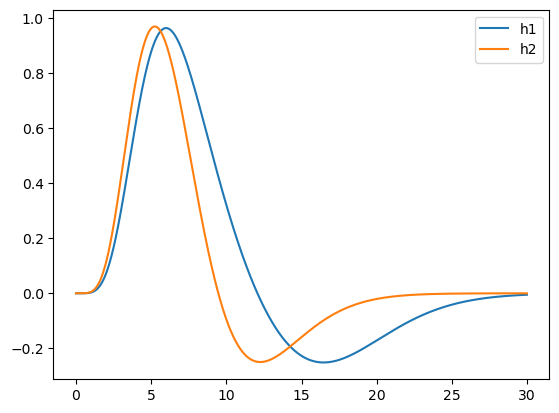

In [4]:
x = [0.01 * t for t in range(0, 3000)]
f1x = [h1(xi) for xi in x]
f2x = [h2(xi) for xi in x]
plt.plot(x, f1x, label='h1')
plt.plot(x, f2x, label='h2')
plt.legend()
plt.show()

In [5]:
def s(t, t_min, t_max):
    if t >= t_min and t <= t_max:
        return 1
    else:
        return 0

In [6]:
def x_coef1(t, t_min=0, t_max=0, alpha1=6, alpha2=16, beta1=1, beta2=1, c=1/6, A=1):
    #return integrate.quad(lambda x: h(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * s(t-x, t_min, t_max), 0, 10)[0]
    return integral(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * \
                    s(t-x, t_min, t_max), 0, t, step = 0.01)

In [7]:
def x_coef2(t, t_min=0, t_max=0, alpha1=6, alpha2=16, beta1=1, beta2=1, c=1/6, A=1):
    #return integrate.quad(lambda x: h(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * s(t-x, t_min, t_max), 0, 10)[0]
    return integral(lambda x: h2(x, a1=6, a2=12, b1=0.9, b2=0.9, c=0.35) * \
                    s(t-x, t_min, t_max), 0, t, step = 0.01)

In [8]:
def x_coef3(t, t_min=0, t_max=0, alpha1=6, alpha2=16, beta1=1, beta2=1, c=1/6, A=1):
    #return integrate.quad(lambda x: h(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * s(t-x, t_min, t_max), 0, 10)[0]
    return integrate.quad(lambda x: h2(x, a1=6, a2=12, b1=0.9, b2=0.9, c=0.35) * \
                          s(t-x, t_min, t_max), 0, t, limit=100, epsrel=1e-3)[0]

In [9]:
def x_coef4(t, t_min=0, t_max=0, alpha1=6, alpha2=16, beta1=1, beta2=1, c=1/6, A=1):
    #return integrate.quad(lambda x: h(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * s(t-x, t_min, t_max), 0, 10)[0]
    if t < t_min:
        return 0
    elif t >= t_min and t <= t_max:
        return integrate.quad(lambda x: h1(t-x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A), t_min, t, limit=100, epsrel=1e-6)[0]
    elif t > t_max:
        return integrate.quad(lambda x: h1(t-x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A), t_min, t_max, limit=100, epsrel=1e-6)[0]



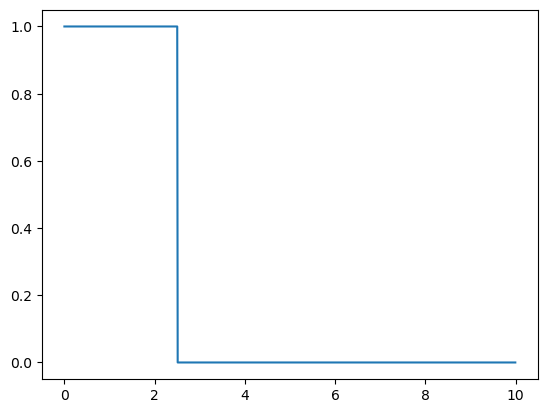

In [10]:
x = [0.01 * t for t in range(0, 1000)]
fx = [s(xi, t_min=0, t_max=2.5) for xi in x]
plt.plot(x, fx)
plt.show()

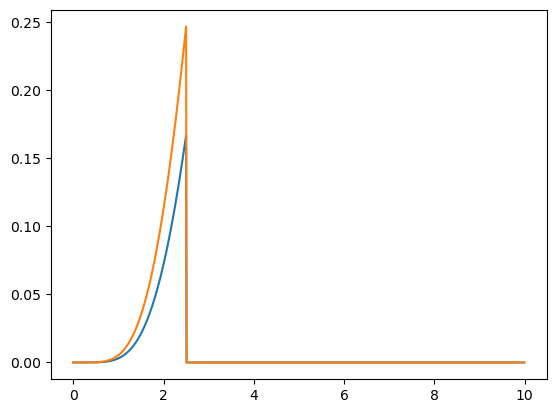

In [11]:
t = 5
x = [0.01 * t for t in range(0, 1000)]
f1x = [h1(xi) * s(t-xi, t_min=2.5, t_max=5) for xi in x]
f2x = [h2(xi) * s(t-xi, t_min=2.5, t_max=5) for xi in x]
plt.plot(x, f1x, label='x1')
plt.plot(x, f2x, label='x2')
plt.show()

In [12]:
def integral(f, x_min, x_max, step=None):
    if step is None:
        step = (x_max - x_min) / 100
    answer = 0
    x = x_min
    while x <= x_max:
        answer = answer + f(x) * step
        x = x + step
    return answer
    

f1 за 0.656588077545166
f2 за 2.5278689861297607
f3 за 0.9579904079437256
f4 за 0.01624131202697754


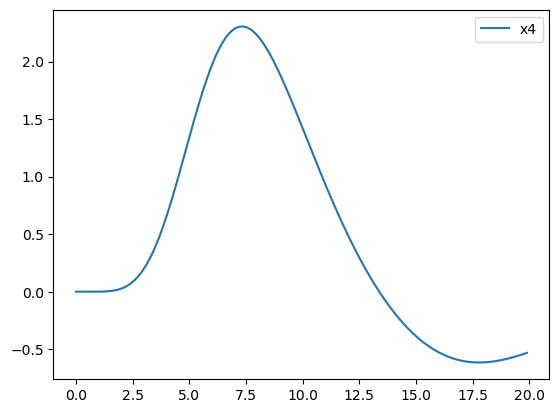

In [13]:
x = [0.1 * t for t in range(0, 200)]

t0 = time.time()
f1x = [x_coef1(xi, t_min=0, t_max=2.5) for xi in x]
t1 = time.time()
f2x = [x_coef2(xi, t_min=0, t_max=2.5) for xi in x]
t2 = time.time()
f3x = [x_coef3(xi, t_min=0, t_max=2.5) for xi in x]
t3 = time.time()
f4x = [x_coef4(xi, t_min=0, t_max=2.5) for xi in x]
t4 = time.time()
print('f1 за', t1-t0)
print('f2 за', t2-t1)
print('f3 за', t3-t2)
print('f4 за', t4-t3)
#plt.plot(x, f1x, label='x1')
#plt.plot(x, f2x, label='x2')
#plt.plot(x, f3x, label='x3')
plt.plot(x, f4x, label='x4')
plt.legend()
plt.show()


In [14]:
setka = [2.5 * i for i in range(1, 40)]
print([round(x_coef4(xi, t_min=0, t_max=2.5), 3) for xi in setka])

[0.085, 1.342, 2.299, 1.421, 0.297, -0.386, -0.613, -0.524, -0.326, -0.161, -0.067, -0.024, -0.007, -0.002, -0.001, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Тут можем менять функцию гемодинамичкеского ответа.
</div>


In [38]:
def design_matrix(frametimes, slicetimes=0, events=np.array([[1, 0]]), S=None, 
               hrf_parameters=np.array([[5.4, 5.2, 10.8, 7.35, 0.35]]), shift=None, voxel=None):
    z = voxel[2]
    nd = 84
    matrix = np.zeros((84, 28))
    eventime = events[:, 1]
    evendur = events[:, 2]
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            t = frametimes[i] + slicetimes[z]
            #print(eventime[j])
            #print(evendur[j])
            #print(matrix[i, j])
            matrix[i, j] = x_coef4(t, t_min=eventime[j], t_max=eventime[j]+evendur[j])
    return matrix
            

In [39]:
def print_matrix(matrix):
    m, n = matrix.shape
    for i in range(m):
        for j in range(n):
            elem = matrix[i, j]
            print("{0:0.2f}".format(elem), end=', ')
        print()

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Надо проверить генерацию матрицы на простом примере.
</div>


Фунция для получения матрицы дизайна по файлу логов

In [40]:
def get_design_matrix(logs_file, voxel, nX, nY, nZ, nR, nT):
    FRAME_TIMES = get_FRAME_TIMES(logs_file, nX, nY, nZ, nR, nT)
    SLICE_TIMES = get_SLICE_TIMES(logs_file, nX, nY, nZ, nR, nT)
    EVENTS = get_EVENTS(logs_file, nX, nY, nZ, nR, nT)
    #print('getting design matrix')
    #print("FRAME_TIMES:\n", FRAME_TIMES)
    #print("SLICE_TIMES:\n", SLICE_TIMES)
    #print("EVENTS:\n", EVENTS)
    #answer_dict = fmridesign2(FRAME_TIMES, SLICE_TIMES, EVENTS)
    #DESIGN_MATRIX = answer_dict['X'][:, :, 0]
    DESIGN_MATRIX = design_matrix(FRAME_TIMES, SLICE_TIMES, EVENTS, voxel=voxel)
    #print('Размеры:', DESIGN_MATRIX.shape)
    return DESIGN_MATRIX

$nX$ - число вокселей по оси X

$nY$ - число вокселей по оси Y

$nZ$ - число вокселей по оси Z

$nT$ - число моментов времени

$nS$ - число предъявляемых стимулов

$nV = nX\times nY\times nZ$ - число вокселей

$nR$ - число прогонов

In [41]:
'''
voxels_dict = {}
Y = np.zeros((nV, nR, nT))
X = np.zeros((nV, nR, nT, nS))
for x in range(nX):
    for y in range(nY):
        for z in range(nZ):
            v = z * nX * nY + y * nX + x
            voxels_dict[v] = [x,y,z]
''';


Не хватает места, чтобы хранить сразу все матрицы $X$ и $Y$ -> рассчитываем их при необходимости

## 3. Задание матриц и векторов

Уравнение регрессии:
$Y_i = X_i \beta_i + e_i$

Такое уравнение имеем для каждого вокселя

$Y_i$ - вектор интенсивности вокселей по сканам в $i$-м прогоне

$e_i$ - вектор нормального шума

$X_i$ - матрица скан x стимул в $i$-м прогоне

$(X_i)_{jk}$ - эффект $k$-го стимула на воксель на $j$-м скане в $i$-м прогоне

$\beta_i$ - вектор параметров регрессии

$(\beta_i)_k$ - "важность" $k$-го стимула

### 3.1. Загрузка данных МРТ в вектор $Y$, рассчет значений матрицы $X$

In [42]:
'''
for p in range(nP): #пациент
    for v in range(nV): #воксель
        for r in range(nR): #прогон
            for t in range(nT): #момент времени
                Y[p,v,r,t] = MRI_data[p][r][voxel_dict[v].extend(t)]
                for s in range(nS): #стимул
                    X[p,v,r,t,s] = get_design_matrix(MRI_logs) 
''';

Тоже пока не рассчитываем

### 3.2. При необходимости расчет матрицы $X^*$ (расчетная матрица для оценки эффектов типов задач)

$\beta_i = B^T x_i^* + f_i$

$B$ - матрица $k^*$ x $k$, содержащая параметры многомерной регрессии. 

$k^*$ - число эффектов задач

$k$ - длина $\beta_i$

$X^*$ - матрица проектирования для оценки эффектов задач. Размер $M$ x $k^*$ - прогон х число типов задач

$x_i^*$ - $i$-я строка в $X^*$ 

$M$ - число параметров регрессии $\beta_i$

In [43]:
M = 28

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Число параметров регрессии (число стимулов в датасете). Лучше вынести в начало кода и переобозначить, точно такой же буквой обозначено число прогонов.
</div>


В случае моего датасета мы имеет 2 типа задач: Классификация 'Я'/'Не я' для последовательности изображений Знакомых и Незнакомых людей. То есть k* = 2

Пока делаем, как написано в статье

In [44]:
k = nS
k2 = 2
X2 = [[1,1],[1,1],[1,1],[1,1],[1,-1],[1,-1],[1,-1],[1,-1]]
X2 = np.array(X2)

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Тут пока не очень понятен вид матрицы $X^*$. Он будет зависеть от того, хотим мы объединять прогоны str и fr в один прогон или нет. Если объединяем, то это просто матрица - столбец из единиц длины в количество прогонов, т.е. 4. Если не объединяем, то матрица имеет представленный вид. 
</div>


## 4. Предварительное "отбеливание" вектора $Y$ и матрицы $X$ (удаление автокорреляций)

Выбираем $\rho$ : $|\rho|<1$

Вектор $Y$ и матрица $X$ после обработки:

$\tilde{Y_1} = Y_1$, $\tilde{Y_i} = (Y_i - Y_{i-1})/\sqrt{1-\rho^2}$

$\tilde{x_1} = x_1$, $\tilde{x_i} = (x_i - x_{i-1})/\sqrt{1-\rho^2}$

Последовательно преобразовываем каждый элемент $X$ и $Y$

удаление автокорелляций последовательности матриц

Фунция принимает на вход список матриц по прогонам для удаления автокорреляции и параметр ро

In [45]:
def pre_whitening(array_matrixes, rho=0.5):
    new_array_matrixes = np.zeros(array_matrixes.shape)
    for i in range(len(array_matrixes)):
        if i == 0:
            new_array_matrixes[i] = array_matrixes[i]
        else:
            new_array_matrixes[i] = (array_matrixes[i] - rho * array_matrixes[i-1])/(1 - rho**2)**0.5
    return new_array_matrixes

$p$ - номер испытуемого

$r$ - номер прогона

$v$ - номер вокселя

In [46]:
'''
rho = 0.5
for p in range(nP):
    for v in range(nV):
        new_Y = np.zeros((nR, nT))
        new_X = np.zeros((nR, nT, nS))
        for r in range(nR):
            if r > 0:
                new_Y[r] = (Y[p,v,r] - Y[p,v,r-1])/(1-rho**2)**0.5
                new_X[r] = (X[p,v,r] - X[p,v,r-1])/(1-rho**2)**0.5
            else:
                new_Y[r] = Y[p,v,r]
                new_X[r] = X[p,v,r]
        Y[p,v] = copy.deepcopy(new_Y)
        X[p,v] = copy.deepcopy(new_X)
''';

Тут будет проблема с загрузкой/памятью. Данные об отдельном вокселей - это небольшая часть каждого из сканов. Может быть так, что мы не сможем считать всё это. Возможно стоит перезаписать новые файлы в память на время работы программы. Либо же как-то по-умному обращаться к нужным ячейкам памяти, а не открытать все файлы 2,5 млн. раз.

Функция для получения матриц $X$ для последовательности прогонов по пути до папки с логами

In [47]:
def get_X(patient_logs_path=None, voxel=None, nX=None, nY=None, nZ=None, nR=None, nT=None):
    #print('Получаем матрицы X')
    logs_dict = load_patient_logs(patient_logs_path)
    logs_files = list(logs_dict.values())
    rho = 0.5
    X_list = [0 for i in range(len(logs_files))]
    for r in range(len(logs_files)):
        #display(logs_files[r])
        t1 = time.time()
        X = get_design_matrix(logs_files[r], voxel, nX, nY, nZ, nR, nT)
        t2 = time.time()
        #print('Одна матрица X:', t2-t1)
        #print(X)
        X_list[r] = copy.deepcopy(X)
        t3 = time.time()
        #print('С копированием:', t3-t1)
        #print
    X_array = np.array(X_list)
    #print('До предобработки')
    #print(X_array)
    X_prew_array = pre_whitening(X_array, rho)
    #print('После предобработки')
    #print(X_prew_array)
    return X_prew_array

Функция для получения векторов $Y$ для последовательности прогонов по пути до папки со сканами прогонов

In [48]:
def get_Y(patient_data_path=None, voxel=None, Y_paths=None):
    rho = 0.5
    Y_list = []
    t1 = time.time()
    if Y_paths == None:
        patient_data_dict = load_patient_data(patient_data_path)
        for run in patient_data_dict.keys():
            Y_list.append(np.array([scan[voxel] for scan in patient_data_dict[run]]))
    else:
        for Y_path in Y_paths:
            Y_list.append(np.load(Y_path))
    t2 = time.time()
    #print('Y Загружен за', t2-t1)
    Y_array = np.array(Y_list)
    Y_prew_array = pre_whitening(Y_array, rho)
    t3 = time.time()
    #print('Обработан за', t3-t1)
    return Y_prew_array

Тоже пока не нужно

## 5. Применение EM-алгоритма

$\Omega$ - ковариационная матрица $\beta_i$

$\mu$ - вектор средних $\beta_i$

$\sigma_i^2$ - квадрат дисперсии $y_i$

### E-step:

$h_i \equiv E(\beta_i | \sigma_i^2, \mu_i, \Omega, X_i, y_i) =(\Omega^{-1} + \sigma_i^{-2}(X_i^T X_i))^{-1}(\Omega^{-1}\mu_i + \sigma_i^{-2}X_i^T y_i)$

$H_i \equiv E(\beta_i \beta_i^T | \sigma_i^2, \mu_i, \Omega, X_i, y_i ) - h_i h_i^T =(\Omega^{-1} + \sigma_i^{-2} (X_i^T X_i))^{-1}$

### M-step:

$\mu_i^{(r+1)} = (B^{(r)})^T x_i^*$

$B^{(r)} = ((X^*)^T X^*)^{-1}(X^*)^T Z^{(r)}$

$\Omega^{(r+1)} = \frac{1}{M-k^*}\{\sum_i$ $(H_i^{(r)} + h_i^{(r)} (h_i^{(r)})^T) - \frac{1}{M}\mu^{(r)} (\mu^{(r)})^T \}$

$\mu^{(r)} = \sum_i \mu_i^{(r)}$

$\sigma_i^{2(r+1)} = \frac{1}{n-k}||y_i - X_i \beta_i^{(r)}||^2$

Среднеквадратичное расстояние между двумя векторами

In [49]:
def MSE(v1, v2):
    if v1.shape != v2.shape:
        print("Векторы разной длины: ", v1.shape, " != ", v2.shape)
        return None
    answer = 0
    for i in range(len(v1)):
        diff = (v1[i] - v2[i])**2
        answer = answer + diff
    return answer

Функция расстояния между матрицами для критерия остановки EM-алгоритма

In [50]:
def avg_diff2(matrix1, matrix2):
    if matrix1.shape != matrix2.shape:
        print('Разный размер')
        return None
    summ = 0
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            summ += abs(matrix1[i][j] - matrix2[i][j])
    #print(summ, matrix1.shape)
    return summ / (matrix1.shape[0] * matrix1.shape[1])

In [51]:
def avg_diff3(matrix1, matrix2):
    if matrix1.shape != matrix2.shape:
        print('Разный размер')
        return None
    summ = 0
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            for k in range(matrix1.shape[2]):
                summ += abs(matrix1[i][j][k] - matrix2[i][j][k])
    #print(summ, matrix1.shape)
    return summ / (matrix1.shape[0] * matrix1.shape[1] * matrix1.shape[2])

## Выбрать условие сходимости

Функция для запуска EM-алгоритма

На вход: Матрицы $X$ и $Y$ для прогонов одного пациента, матрица $X2$ ($X^*$) эффектов задач

На выход: Оценки $h$ и $H$ среднего и дисперсии параметров регрессии

In [52]:
def run_EM(X_matrixes, Y_matrixes, X2):
    #print('Матрицы для EM-алгоритма:')
    #print('Матрицы X', X_matrixes.shape)
    #print(X_matrixes)
    #print('Матрицы Y', Y_matrixes.shape)
    #print(Y_matrixes)
    #Изначально Гиперпараметры Omega, Sigma2, Mu, X* - просто какие-то
    h = np.ones((nR, nS)) #прогон стимул
    H = np.zeros((nR, nS, nS)) #прогон стимул^2
    for r in range(nR):
        for s in range(nS):
            H[r][s, s] = 1
    
    k2 = X2.shape[1]
    M = X2.shape[0]
    n = Y_matrixes[0].shape[0] # пока так, не очень понятно, что такое n
    #Берём простой вид Omega, Sigma2 и Mu
    Omega = np.eye(nS) # ковариационная матрица стимулов
    Sigma2 = np.ones(nR)
    Mu = np.ones((nR, nS)) #для каждого прогона это вектор средних параметров регрессии
    curr_vars = {'Omega':Omega, 'Sigma2':Sigma2, 'Mu':Mu, 'h':h, 'H':H}
    prev_vars = {'Omega':Omega, 'Sigma2':Sigma2, 'Mu':Mu, 'h':h, 'H':H}
    #X_i - матрица регрессии, задана заранее
    #X2 задана заранее = X*
    #k2 задано заранее = k*
    n_iter = 0
    while ((avg_diff2(curr_vars['h'], prev_vars['h']) > 0.001) \
    or (avg_diff3(curr_vars['H'], prev_vars['H']) > 0.001) or (n_iter < 2)) and all(curr_vars['Sigma2'] > 0.000001):
        # запоминаем 'старые' оценки значений
        prev_vars['Omega'] = copy.deepcopy(curr_vars['Omega'])
        prev_vars['Sigma2'] = copy.deepcopy(curr_vars['Sigma2'])
        prev_vars['Mu'] = copy.deepcopy(curr_vars['Mu'])
        prev_vars['h'] = copy.deepcopy(curr_vars['h'])
        prev_vars['H'] = copy.deepcopy(curr_vars['H'])
        for i in range(nR):#по всем прогонам
            Xi = X_matrixes[i]
            yi = Y_matrixes[i]
            Mui = prev_vars['Mu'][i]
            Sigma2i = prev_vars['Sigma2'][i]
            #print(prev_vars['Omega'])
            invOmega = np.linalg.inv(prev_vars['Omega'])
            
            #Оценка среднего
            #print(invOmega.shape, Sigma2i.shape, Xi.shape, Mui.shape, yi.shape)
            #print(Sigma2i)
            #print(invOmega)
            #print(Xi.T @ Xi)
            #print(invOmega + (1/Sigma2i) * (Xi.T @ Xi))
            h[i] = np.linalg.inv(invOmega + (1/Sigma2i) * (Xi.T @ Xi)) @ (invOmega @ Mui + (1/Sigma2i) * Xi.T @ yi)
            
            #Оценка дисперсии
            H[i] = np.linalg.inv(invOmega + 1 / Sigma2i * (Xi.T @ Xi))
            
        
        curr_vars['h'] = copy.deepcopy(h)
        curr_vars['H'] = copy.deepcopy(H)

        #M-шаг
        B = np.linalg.inv(X2.T @ X2) @ X2.T @ prev_vars['h'] #здесь не до конца уверен, что берем именно предыдущую оценку для h
        for i in range(nR):
            Mu[i] = B.T @ X2[i, :]
        curr_vars['Mu'] = copy.deepcopy(Mu)
        Mu_sum = sum(prev_vars['Mu']) #тут тоже не 100% уверенность, что используем предудущие
        
        Omega = (1/(M-k2) * (sum([prev_vars['H'][i] + prev_vars['h'][i] @ prev_vars['h'][i].T \
                                  for i in range(nR)]) - (1/M) * Mu_sum @ Mu_sum.T)  )
        curr_vars['Omega'] = copy.deepcopy(Omega)
        for i in range(nR):
            yi = Y_matrixes[i]
            Xi = X_matrixes[i]
            hi = prev_vars['h'][i]
            Sigma2[i] = (1/(n-k)) * MSE(yi, Xi @ hi) #тут нет уверенности, что такое n
        curr_vars['Sigma2'] = copy.deepcopy(Sigma2)

        n_iter += 1
    #print(f'Остановились на {n_iter} итерациях')
    #print(f'avg_diff2 = {avg_diff2(curr_vars['h'], prev_vars['h'])}')
    #print(f'avg_diff3 = {avg_diff3(curr_vars['H'], prev_vars['H'])}')
    #print(curr_vars['h'])
    #print(prev_vars['h'])
    #print(curr_vars['Sigma2'])
    return curr_vars['h'], curr_vars['H']

In [53]:
'''
#Изначально Гиперпараметры Omega, Sigma2, Mu, X* - просто какие-то
h = np.zeros((nP, nV, nR))#воксель прогон 
H = np.zeros((nP, nV, nR))

#Берём простой вид Omega, Sigma2 и Mu
Omega = np.eye(nS)
Sigma2 = 1
Mu = np.ones(nS)

#X_i - матрица регрессии, задана заранее
#X2 задана заранее = X*
#k2 задано заранее = k*
X2T = X2.transpose()
for p in range(nP):
    for v in range(nV):#по всем вокселям
        while "Условие сходимости" :
            
            #Набор матриц для p-го пациента и v-го вокселя
            X_matrixes = get_X(p, v, nR, nT, nS, MRI_logs, number_patients_runs_dict)
            Y_matrixes = get_Y(p, v, nX, nY, nZ, nR, nT, MRI_data)
            for i in range(nR):#по всем прогонам
                Xi = X_matrixes[i]
                yi = Y_matrixes[i]
                Mui = Mu[i]
                Sigma2i = Sigma2[i]
                XiT = Xi.transpose()
                invOmega = np.linalg.inv(Omega)
                
                #Оценка среднего
                h[p,v,i] = np.dot(np.linalg.inv(invOmega + (1/Sigma2i)*np.dot(XiT, Xi)), \
                                  np.dot(invOmega, Mui) + (1/Sigma2i)*np.dot(XiT, yi))
                
                #Оценка дисперсии
                H[p,v,i] = np.linalg.inv(invOmega + (1/Sigma2i)*np.dot(XiT, Xi))
                
            #M-шаг
            
            
            B = np.dot(np.linalg.inv(np.dot(X2T, X2)), np.dot(X2T, h[v]))
            for i in range(nR):
                Mu[i] = np.dot(np.transpose(B),X2[i, :])
            Mu_sum = sum(Mu)
            
            Omega = (1/(M-k2) * (sum([H[v,i] + np.dot(h[v,i], np.transpose(h[v,i])) \
                                      for i in range(nR)]) - (1/M) * np.dot(Mu_sum, np.transpose(Mu_sum)))  )
            for i in range(nR):
                yi = Y_matrixes[i]
                Xi = X_matrixes[i]
                hi = h[p,v,i]
                Sigma2[i] = (1/(n-k)) * MSE(yi, np.dot(Xi, hi))
''';

Функция для запуска рассчета оценок параметров регрессии

На вход: пути до папки с прогонами и логами одного пациента, номер вокселя

На выход: Оценки среднего и дисперсии для параметров регрессии

In [54]:
def run_regression(patient_data_path=None, patient_logs_path=None, voxel=None, X2=None, voxel_data=None):
    if voxel_data == None:
        t1 = time.time()
        X_list = get_X(patient_logs_path, voxel) #матрицы дизайна для прогонов
        print('Матрица дизайна:\n', X_list[0])
        t2 = time.time()
        Y_list = get_Y(patient_data_path, voxel) #столбец состояния вокселя на сканах для прогонов
        print('Столбец интенсивности вокселя:\n', Y_list[0])
        t3 = time.time()
        mean_beta, disp_beta = run_EM(X_list, Y_list, X2)
        t4 = time.time()
        #print('Матрица X:', t2-t1)
        #print('Матрица Y:', t3-t2)
        #print('EM-алгоритм:', t4-t3)
        return mean_beta, disp_beta

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b> Нужно проверить EM-алгоритм на простом примере.
</div>


## Пока что забиваем на это, идеи кончились, так что просто взяли рандомную матрицу и всё

### Гауссово ядро 

In [55]:
def gauss_smooth(data):
    new_data = gaussian_filter(input=data, radius=0.8)
    return new_data

## 6. Вычисление $M$ значений $t_i^{(+)}$ для каждого вокселя ($M$-число прогонов)

$t_i^{(+)} = \frac{\hat{\beta}_i^{(+)}}{\sqrt{\hat{\sigma}_{\beta_i^{(+)}}^2}}$

Contrast-массив размера nS, сумма элементов которого равна 0

Применяется так: Выбираются часть условий, которые берутся с коэффициентом '1', и часть условий с коэффициентом '-1'. Тогда значение $t_i^{(+)}$ будет показывать величину разницы между реакциями на эти стимулы.

В нашем случае имеем 28 стимулов на прогон

Нужно составить контраст

По идее будем его составлять на основании эмоций, т.е. выберем какой-то контраст для выявления шизофрении

И при этом нужно учесть значение simularities, т.е. скорее всего коэффициенты будут разными и зависеть от значения simularities

Функция для рассчета t-статистики контраста от параметров регресии

Вход: оценки среднего и дисперсии параметров регрессии, контраст

Выход: список значений t-статистики, по одному на каждый прогон пациента

In [56]:
def get_t_value(mean_beta, disp_beta, contrast):
    #disp_beta = gauss_smooth(disp_beta)
    t_value_list = np.array([np.sum(np.array([mean_beta[i, j] * contrast[j] for j in range(len(contrast))])) \
                             / np.sqrt(np.sum(np.array([[contrast[j]*contrast[k]*disp_beta[i, j, k] for j in range(len(contrast))] \
                                           for k in range(len(contrast))]))) for i in range(mean_beta.shape[0])])
    return t_value_list

In [57]:
#Contrast = np.array([1 if i%2==0 else -1 for i in range(M)]) #Пока взяли 'какой-то контраст'

## 7. Вычисление значения $T^{(+)}$ для каждого вокселя

$T^{(+)} = \frac{\hat{B}^{(+)}}{\sqrt{\hat{\sigma}_{B^{(+)}}^2}}$

Пока пропускаем, м.б. и не нужно

Рассчет T-значений параметров регрессии по вектору контраста

Вход: оценки среднего и дисперсии параметров регрессии, контраст

Выход: Одно значение T-статистики

In [58]:
def get_T_value(mean_beta, disp_beta, contrast):
    #disp_beta = gauss_smooth(disp_beta)
    T_value = sum(get_t_value(mean_beta, disp_beta, contrast))
    return T_value

## 8. Выбор порогов и разделение значений $t_i^{(+)}$

### 8.1. Выбор $K$ различных порогов в порядке возрастания

Мы имеем nV*nR значений t-value

Тестируем несколько значений K=10,15,20,25

Тестируем разные варианты выбора самих порогов

Имеем выборку из nV*nR элементов. Делим на группы по:

1) Количеству элементов

2) Значению (min, max) интервал делим на K равных частей

3) Случайный выбор порогов

4) Статистический

Функция для рассчета словаря порогов

Вход: Список числа порогов, список списков t-значений (воксель, прогон -> t-значение)

Выход: Словарь порогов (число порогов -> список порогов)

In [59]:
def voxel_coord(v, nX, nY, nZ):
    return v // (nX * nY), (v % (nX * nY)) // nY,  (v % (nX * nY)) % nY

In [60]:
def coord_voxel(x, y, z, nX, nY, nZ):
    return nX * nY * z + nX * y + x

In [61]:
def get_thresholds_dict(K_list, t_values):
    t_values_list = []
    for v in range(t_values.shape[0]):
        for r in range(t_values.shape[1]):
            t_values_list.append(t_values[v, r])
    t_values_list_sorted = sorted(t_values_list)
    min_value = min(t_values_list)
    max_value = max(t_values_list)
    dict_thresholds = {}
    dict_thresholds['numb'] = {}
    dict_thresholds['value'] = {}

    for K in K_list:
        n_elem = t_values.shape[0] * t_values.shape[1] // (K+1)
        dict_thresholds['numb'][K] = []
        dict_thresholds['value'][K] = []
        #dict_random_thresholds[K] = []
        for i in range(0, K):
            dict_thresholds['numb'][K].append(t_values_list_sorted[i * n_elem])
            dict_thresholds['value'][K].append(min_value + (max_value - min_value) * i / K)
    return dict_thresholds

In [62]:
K_list = [10, 15, 20, 25, 30, 50, 100, 250]

Создаем список всех t-value

In [63]:
'''
t_value_list = []
for p in range(nP):
    for v in range(nV):
        for r in range(nR):
            t_value_list.append(t_value[p,v,r])
t_value_list_sorted = sorted(t_value_list)
''';

Минимальное и максимальное t_value, Рассчет порогов двумя способами

In [64]:
'''
min_value = min(t_value_list)
max_value = max(t_value_list)
dict_numb_thresholds = {}
dict_value_thresholds = {}
#dict_random_thresholds = {}
for K in K_list:
    n_elem = nV * nR // (K+1)
    dict_numb_thresholds[K] = []
    dict_value_thresholds[K] = []
    #dict_random_thresholds[K] = []
    for i in range(1, K+1):
        dict_numb_tresholds[K].append(t_values_list_sorted[i * n_elem])
        dict_value_thresholds[K].append(min_value + (max_value - min_value) * i / K)
        #dict_random_thresholds

''';    

### 8.2. Для каждого вокселя делим $M$ значений $t_i^{(+)}$ на $(K+1)$ группу. Число элементов в группе $k$ равно $r_k$. 

номер испытуемого, номер вокселя, K-число порогов,группы 

Функция для разделения t-значений на группы с учетом порогов

Вход: 2 словарь порогов, список списков t-значений

Выход: Словарь разделения t-значений по группам (воксель, numb/value, количество порогов -> количество t-значений вокселя в группе)

In [65]:
def get_t_groups(K_list, dict_thresholds, t_value):
    t_value_voxel_groups = {}
    t_value_voxel_groups['numb'] = {}
    t_value_voxel_groups['value'] = {}
    for K in K_list:
        t_value_voxel_groups['numb'][K] = np.zeros((nV, K+1))
        t_value_voxel_groups['value'][K] = np.zeros((nV, K+1))
        for v in range(t_value.shape[0]):
            for n_group in range(0, K+1):
                if n_group == 0:
                    
                    #Нулевая группа - все, что меньше нулевого порога
                    t_value_voxel_groups['numb'][K][v][n_group] = len([t for t in t_value[v] \
                                                                     if (t < dict_thresholds['numb'][K][n_group])])
                    t_value_voxel_groups['value'][K][v][n_group] = len([t for t in t_value[v] \
                                                                      if (t < dict_thresholds['value'][K][n_group])])
                elif n_group == K:
                    
                    #K-я группа - все, что больше (K-1)-го порога
                    t_value_voxel_groups['numb'][K][v][n_group] = len([t for t in t_value[v] \
                                                                     if (t > dict_thresholds['numb'][K][n_group - 1])])
                    t_value_voxel_groups['value'][K][v][n_group] = len([t for t in t_value[v] \
                                                                      if (t > dict_thresholds['value'][K][n_group - 1])])
                else:
                    
                    #i-я группа - от (i-1)-го до i-го порога
                    t_value_voxel_groups['numb'][K][v][n_group] = len([t for t in t_value[v] \
                                                                     if (t > dict_thresholds['numb'][K][n_group - 1] \
                                                                         and t < dict_thresholds['numb'][K][n_group])])
                    t_value_voxel_groups['value'][K][v][n_group] = len([t for t in t_value[v] \
                                                                      if (t > dict_thresholds['value'][K][n_group - 1] \
                                                                          and t < dict_thresholds['value'][K][n_group])])
    return t_value_voxel_groups #Это значения r, которые нужны для функции правдоподобия

In [66]:
'''
t_value_voxel_groups = np.array((nP, nV))
for p in range(nP):
    for v in range(nV):
        t_value_voxel_groups[p,v] = {}
        t_value_voxel_groups[p,v]['numb'] = {}
        t_value_voxel_groups[p,v]['value'] = {}
        for K in K_list:
            for n_group in range(0, K+1):
                if n_group == 0:
                    
                    #Нулевая группа - все, что меньше нулевого порога
                    t_value_voxel_groups[p,v]['numb'][K].append(len([t for t in t_value[p,v] \
                                                                     if (t < dict_numb_thresholds[n_group])]))
                    t_value_voxel_groups[p,v]['value'][K].append(len([t for t in t_value[p,v] \
                                                                      if (t < dict_value_thresholds[n_group])]))
                elif n_group == K:
                    
                    #K-я группа - все, что больше (K-1)-го порога
                    t_value_voxel_groups[p,v]['numb'][K].append(len([t for t in t_value[p,v] \
                                                                     if (t > dict_numb_thresholds[n_group - 1])]))
                    t_value_voxel_groups[p,v]['value'][K].append(len([t for t in t_value[p,v] \
                                                                      if (t > dict_value_thresholds[n_group - 1])]))
                else:
                    
                    #i-я группа - от (i-1)-го до i-го порога
                    t_value_voxel_groups[p,v]['numb'][K].append(len([t for t in t_value[p,v] \
                                                                     if (t > dict_numb_thresholds[n_group - 1] \
                                                                         and t < dict_numb_thresholds[n_group])]))
                    t_value_voxel_groups[p,v]['value'][K].append(len([t for t in t_value[p,v] \
                                                                      if (t > dict_value_thresholds[n_group - 1] \
                                                                          and t < dict_value_thresholds[n_group])]))

#Обращаемся к данным: (Пациент, Воксель, Число порогов, Номер группы(0,1,...,K)) -> число элементов в группе
''';

## 9. Ищем наилучшие значения $P_A$ и $P_I$ (чувствительность и частота ложных классификаций)

### 9.1. Вводим величины $P_{A_k}$, $P_{I_k}$, $\lambda$ (Вероятность классификации активного/неактивного вокселя в $k$-ю группу, доля истинно активных вокселей)

Тут не нужен код

### 9.2. Задаём функцию правдоподобия $L(P_{A_k}, P_{I_k}, \lambda | r)$

### $L(P_{A_k}, P_{I_k}, \lambda | r)$ = $\log(\prod_{v}^{V}$ $[ \lambda \prod_{k=1}^{K+1} P_{A_k}^{r_k^{(v)}}$ +  $(1 - \lambda )$$\prod_{k=1}^{K+1} P_{I_k}^{r_k^{(v)}}])$

$r_k^{(v)}$ - число $t_i^{(+)}$ для вокселя $v$, попавших в группу $k$

$P_{A_k}$ - вероятность истинно активного вокселя быть классифицирован в $k$-ю группу

$P_{I_k}$ - вероятность истинно неактивного вокселя быть классифицирован в $k$-ю группу

$\lambda$ - доля истинно активных вокселей

$V$ - число вокселей

Целевая функция для порогов value

In [67]:
def f_obj(lamda, P_A, P_I, t_values):
    r = t_values
    K = P_A.shape[0]
    V = t_values.shape[0]
    f = np.prod([lamda * \
                   np.prod([P_A[k]**r[v,k] for k in range(K)]) + \
                   (1 - lamda) * np.prod([P_I[k]**r[v,k] for k in range(K)]) \
                   for v in range(V)])
    return f 

In [68]:
def J_obj(lamda, P_A, P_I, t_values):
    r = t_values
    K = P_A.shape[0] - 1
    V = t_values.shape[0]
    J = np.zeros(K * 2 + 3)
    #print(r.shape, K, V)
    J[0] = np.prod([np.prod([P_A[k]**r[v,k] for k in range(K)]) - \
                    np.prod([P_I[k]**r[v,k] for k in range(K)])\
                    for v in range(V)])
    for i in range(1, K+2):
        ind = (i-1)%(K+1)
        J[i] = np.prod([
                        lamda*\
                        np.prod([P_A[k]**r[v,k] for k in [j for j in range(K) if j!=ind]])*\
                       r[v,ind]*P_A[ind]**(r[v,ind]-1)\
                        for v in [j for j in range(V) if r[j,ind]>=1]
                        ])
    for i in range(K+2, 2*K+3):
        ind = (i-1)%(K+1)
        J[i] = np.prod([(1-lamda)*\
                        np.prod([P_I[k]**r[v,k] for k in [j for j in range(K) if j!=ind]])*\
                       r[v,ind]*P_I[ind]**(r[v,ind]-1)\
                       for v in [j for j in range(V) if r[j,ind]>=1]])
    return J

In [69]:
def H_obj(lamda, P_A, P_I, t_values):
    r = t_values
    K = P_A.shape[0]-1
    V = t_values.shape[0]
    H = np.zeros((K * 2 + 3, 2 * K + 3))
    #Элемент (0,0)
    H[0,0] = 0
    #0-й столбец P_A_K
    for i in range(1, K+2):
        ind = (i-1)%(K+1)
        H[0,i] = np.prod([\
                        np.prod([P_A[k]**r[v,k] for k in [l for l in range(K) if l!=ind]])*\
                       r[v,ind]*P_A[ind]**(r[v,ind]-1)\
                       for v in [l for l in range(V) if r[l,ind]>=1]])
    #0-й столбцеw P_I_K
    for i in range(K+2, 2*K+3):
        ind = (i-1)%(K+1)
        H[0,i] = np.prod([-1*\
                        np.prod([P_I[k]**r[v,k] for k in [l for l in range(K) if l!=ind]])*\
                       r[v,ind]*P_I[ind]**(r[v,ind]-1)\
                       for v in [l for l in range(V) if r[l,ind]>=1]])
    #Главная диагональ P_A_k
    for i in range(1, K+2):
        ind = (i-1)%(K+1)
        H[i,i] = np.prod([lamda*\
                        np.prod([P_A[k]**r[v,k] for k in [l for l in range(K) if l!=ind]])*\
                       r[v,ind]*(r[v,ind]-1)*P_A[ind]**(r[v,ind]-2)\
                       for v in [l for l in range(V) if r[l,ind]>=2]])
    #Главная диагональ P_I_k
    for i in range(K+2, 2*K+3):
        ind = (i-1)%(K+1)
        H[i,i] = np.prod([(1-lamda)*\
                        np.prod([P_I[k]**r[v,k] for k in [l for l in range(K) if l!=ind]])*\
                       r[v,ind]*(r[v,ind]-1)*P_I[ind]**(r[v,ind]-2)\
                       for v in [l for l in range(V) if r[l,ind]>=2]])
    #P_A_i P_A_j ниже главной диагонали
    for i in range(1, K+2):
        for j in range(1, i):
            ind1 = (i-1)%(K+1)
            ind2 = (j-1)%(K+1)
            H[i,j] = np.prod([lamda*\
                        np.prod([P_A[k]**r[v,k] for k in [l for l in range(K) if (l!=ind1) and (l!=ind2)]])*\
                       r[v,ind1]*P_A[ind1]**(r[v,ind1]-1)*r[v,ind2]*P_A[ind2]**(r[v,ind2]-1)\
                       for v in [l for l in range(V) if (r[l,ind1]>=1) and (r[l,ind2]>=1)]])
    #P_A_i P_A_j ниже главной диагонали
    for i in range(K+2, 2*K+3):
        for j in range(K+2, i):
            ind1 = (i-1)%(K+1)
            ind2 = (j-1)%(K+1)
            H[i,j] = np.prod([(1-lamda)*\
                        np.prod([P_I[k]**r[v,k] for k in [l for l in range(K) if (l!=ind1) and (l!=ind2)]])*\
                       r[v,ind1]*P_I[ind1]**(r[v,ind1]-1)*r[v,ind2]*P_I[ind2]**(r[v,ind2]-1)\
                       for v in [l for l in range(V) if (r[l,ind1]>=1) and (r[l,ind2]>=1)]])
    #P_I_i P_A_j
    for i in range(K+2, 2*K+3):
        for j in range(1, K+2):
            H[i,j] = 0
    #Симметрия
    for i in range(2*K+3):
        for j in range(i+1, 2*K+3):
            H[i,j] = H[j,i]
    return H

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Первый вид функции правдоподобия, а также её Якобиан и Гессиан. Оптимизация шла плохо: запускалась оптимизация по переменной $\lambda$ и двум векторам $\{P_{A_k}\}$ и $\{P_{I_k}\}$. Оптимизировалась либо только переменная $\lambda$, либо переменная $\lambda$  и один из векторов, при этом второй сохранял начальные значения и нарушались ограничения. 

<b>Этот вид функции был взят из статьи Liou и отличается от функция из статей, на которые она ссылается.
</div>


Альтернативный вариант функции:

Сумма по разным вариантам распределения по группам. В случае $M=4$ имеет 35 вариантов. В случае $M=8$ имеем порядка 8000 слагаемых.

In [70]:
def f_obj_2(lamda, P_A, P_I, t_values):
    r = t_values
    n_t_dict = {}
    K = P_A.shape[0]-1
    V = t_values.shape[0]

    for v in range(V):
        t_numbers_list = tuple(r[v])
        if t_numbers_list not in n_t_dict.keys():
            n_t_dict[t_numbers_list] = 0
        n_t_dict[t_numbers_list] += 1

    f = np.sum([n_t_dict[t_numbers_list] * np.log(lamda * \
                    np.prod([P_A[k]**t[k] for k in range(len(P_A))]) + (1-lamda) * \
                   np.prod([P_I[k]**t[k] for k in range(len(P_A))])) \
                             for t in n_t_dict.keys()])
    
    #f = - np.prod([lamda * \
    #               np.prod([P_A[k]**r[v,k] for k in range(K)]) + \
    #               (1 - lamda) * np.prod([P_I[k]**r[v,k] for k in range(K)]) \
    #               for v in range(V)])
    return f 

In [71]:
def denominator(lamda, P_A, P_I, t):
    K = P_A.shape[0] - 1
    
    return lamda * np.prod([P_A[k]**t[k] for k in range(K)]) + \
    (1-lamda) * np.prod([P_I[k]**t[k] for k in range(K)])

In [72]:
def J_obj_2(lamda, P_A, P_I, t_values):
    r = t_values
    n_t_dict = {}
    K = P_A.shape[0]-1
    V = t_values.shape[0]

    for v in range(V):
        t_numbers_list = tuple(r[v])
        if t_numbers_list not in n_t_dict.keys():
            n_t_dict[t_numbers_list] = 0
        n_t_dict[t_numbers_list] += 1

    J = np.zeros(K * 2 + 3)
    #print(r.shape, K, V)
    J[0] = np.sum([n_t_dict[t] * (np.prod([P_A[k]**t[k] for k in range(K)]) - \
            np.prod([P_I[k]**t[k] for k in range(K)])) / denominator(lamda, P_A, P_I, t)\
                    for t in n_t_dict.keys()])
    for i in range(1, K+2):
        ind = (i-1)%(K+1)
        J[i] = np.sum([n_t_dict[t] * (lamda *\
                        np.prod([P_A[k]**t[k] for k in range(K) if k!=ind]) *\
                       t[ind] * P_A[ind]**(t[ind]-1) )/ denominator(lamda, P_A, P_I, t)\
                        for t in n_t_dict.keys() if t[ind]>=1])
    for i in range(K+2, 2*K+3):
        ind = (i-1)%(K+1)
        J[i] = np.sum([n_t_dict[t] * ((1-lamda) *
                        np.prod([P_I[k]**t[k] for k in range(K) if k!=ind])*\
                       t[ind] * P_I[ind]**(t[ind]-1)) / denominator(lamda, P_A, P_I, t)\
                        for t in n_t_dict.keys() if t[ind]>=1])
    return J

In [73]:
def H_obj_2(lamda, P_A, P_I, t_values):
    r = t_values
    n_t_dict = {}
    K = P_A.shape[0]-1
    V = t_values.shape[0]

    for v in range(V):
        t_numbers_list = tuple(r[v])
        if t_numbers_list not in n_t_dict.keys():
            n_t_dict[t_numbers_list] = 0
        n_t_dict[t_numbers_list] += 1

    H = np.zeros((2 * K + 3, 2 * K + 3))
    #Элемент (0,0)
    H[0,0] = -np.sum([n_t_dict[t] * (np.prod([P_A[k]**t[k] for k in range(K)]) -\
                          np.prod([P_I[k]**t[k] for k in range(K)]))**2 / denominator(lamda, P_A, P_I, t)**2\
                       for t in n_t_dict.keys()])
    
    #0-й столбец P_A_K
    for i in range(1, K+2):
        ind = (i-1)%(K+1)
        H[0,i] = np.sum([n_t_dict[t] * (np.prod([P_A[k]**t[k] for k in range(K) if k!=ind]) *\
                       t[ind] * P_A[ind]**(t[ind]-1) * denominator(lamda, P_A, P_I, t) - \
                       lamda * np.prod([P_A[k]**t[k] for k in range(K) if k!=ind]) * t[ind] * P_A[ind]**(t[ind]-1) * \
                       (np.prod([P_A[k]**t[k] for k in range(K)]) - np.prod([P_I[k]**t[k] for k in range(K)]))) / denominator(lamda, P_A, P_I, t)**2\
                       for t in n_t_dict.keys() if t[ind]>=1])
        
    #0-й столбцеw P_I_K
    for i in range(K+2, 2*K+3):
        ind = (i-1)%(K+1)
        H[0,i] = np.sum([n_t_dict[t] * (-np.prod([P_I[k]**t[k] for k in range(K) if k!=ind]) *\
                       t[ind] * P_I[ind]**(t[ind]-1) * denominator(lamda, P_A, P_I, t) - \
                       (1-lamda) * np.prod([P_I[k]**t[k] for k in range(K) if k!=ind]) * t[ind] * P_I[ind]**(t[ind]-1) * \
                       (np.prod([P_A[k]**t[k] for k in range(K)]) - np.prod([P_I[k]**t[k] for k in range(K)]))) / denominator(lamda, P_A, P_I, t)**2\
                       for t in n_t_dict.keys() if t[ind]>=1])
        
    #Главная диагональ P_A_k
    for i in range(1, K+2):
        ind = (i-1)%(K+1)
        H[i,i] = np.sum([n_t_dict[t] * (lamda *\
                        np.prod([P_A[k]**t[k] for k in range(K) if k!=ind]) *\
                       t[ind]*(t[ind]-1)*P_A[ind]**(t[ind]-2) * denominator(lamda, P_A, P_I, t) - \
           (lamda * np.prod([P_A[k]**t[k] for k in range(K) if k!=ind]) * t[ind] * P_A[ind]**(t[ind]-1))**2) / denominator(lamda, P_A, P_I, t)**2\
                       for t in n_t_dict.keys() if t[ind]>=1])
        
    #Главная диагональ P_I_k
    for i in range(K+2, 2*K+3):
        ind = (i-1)%(K+1)
        H[i,i] = np.sum([n_t_dict[t] * ((1-lamda) *\
                        np.prod([P_I[k]**t[k] for k in range(K) if k!=ind]) *\
                       t[ind]*(t[ind]-1)*P_I[ind]**(t[ind]-2) * denominator(lamda, P_A, P_I, t) - \
           ((1-lamda) * np.prod([P_I[k]**t[k] for k in range(K) if k!=ind]) * t[ind] * P_I[ind]**(t[ind]-1))**2) / denominator(lamda, P_A, P_I, t)**2\
                       for t in n_t_dict.keys() if t[ind]>=1])
        
    #P_A_i P_A_j ниже главной диагонали
    for i in range(1, K+2):
        for j in range(1, i):
            ind1 = (i-1)%(K+1)
            ind2 = (j-1)%(K+1)
            H[i,j] = np.sum([n_t_dict[t] * (lamda *\
                        np.prod([P_A[k]**t[k] for k in range(K) if (k!=ind1) and (k!=ind2)])*\
                       t[ind1]*P_A[ind1]**(t[ind1]-1)*t[ind2]*P_A[ind2]**(t[ind2]-1) * denominator(lamda, P_A, P_I, t) - \
                       (lamda * np.prod([P_A[k]**t[k] for k in range(K) if k!=ind1]) * t[ind1] * P_A[ind1]**(t[ind1]-1)) * \
                       (lamda * np.prod([P_A[k]**t[k] for k in range(K) if l!=ind2]) * t[ind2] * P_A[ind2]**(t[ind2]-1))) / \
                              denominator(lamda, P_A, P_I, t)**2\
                       for t in n_t_dict.keys() if (t[ind1]>=1) and (t[ind2]>=1)])
            
    #P_I_i P_I_j ниже главной диагонали
    for i in range(K+2, 2*K+3):
        for j in range(K+2, i):
            ind1 = (i-1)%(K+1)
            ind2 = (j-1)%(K+1)
            H[i,j] = np.sum([n_t_dict[t] * ((1-lamda) *\
                        np.prod([P_I[k]**t[k] for k in range(K) if (k!=ind1) and (k!=ind2)]) *\
                       t[ind1]*P_I[ind1]**(t[ind1]-1)*t[ind2]*P_I[ind2]**(t[ind2]-1) * denominator(lamda, P_A, P_I, t) - \
                       ((1-lamda) * np.prod([P_I[k]**t[k] for k in range(K) if k!=ind1]) * t[ind1] * P_I[ind1]**(t[ind1]-1)) * \
                       ((1-lamda) * np.prod([P_I[k]**t[k] for k in range(K) if k!=ind2]) * t[ind2] * P_I[ind2]**(t[ind2]-1))) / \
                              denominator(lamda, P_A, P_I, t)**2\
                       for t in n_t_dict.keys() if (t[ind1]>=1) and (t[ind2]>=1)])
            
    #P_I_j P_A_i
    for j in range(K+2, 2*K+3):
        for i in range(1, K+2):
            ind1 = (i-1)%(K+1)
            ind2 = (j-1)%(K+1)
            H[i,j] = np.sum([n_t_dict[t] * (lamda * np.prod([P_A[k]**t[k] for k in range(K) if k!=ind1]) * t[ind1] * P_A[ind1]**(t[ind1]-1) * \
        lamda * np.prod([P_I[k]**t[k] for k in range(K) if k!=ind2]) * t[ind2] * P_I[ind2]**(t[ind2]-1)) / denominator(lamda, P_A, P_I, t)**2 \
                            for t in n_t_dict.keys() if t[ind1]>=1 and t[ind2]>=1])

    #Симметрия
    for i in range(2*K+3):
        for j in range(i+1, 2*K+3):
            H[i,j] = H[j,i]
    return H

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Второй вид функции, взят из статьи Genovese 1997, пока не тестировался. Необходимо рассчитать Якобиан и Гессиан, а также протестировать решатели для этой функции.
</div>


Целевая функция для порогов numb

In [74]:
'''
def f_obj_value(lamda, P_A, P_I, t_value_voxel_groups):
    f = np.log(lamda * np.prod([P_A_k**t_value_voxel_groups['value'][v][K][k] \
                                for k, P_A_k in enumerate(P_A)]) + (1 - lamda) * \
               np.prod([P_I_k**t_value_voxel_groups['value'][v][K][k] for k, P_I_k in enumerate(P_I)]))
    return f
''';

### Ограничения:
### 1) $\forall   k \; P_{A_k} \geq 0$
### 2) $\forall   k \; P_{I_k} \geq 0$
### 3) $\sum_{k=0}^{K} P_{A_k} = 1$ -> $\sum_{k=0}^{K} P_{A_k} \geq 1$ & $\sum_{k=0}^{K} P_{A_k} \leq 1$
### 4) $\sum_{k=0}^{K} P_{I_k} = 1$ -> $\sum_{k=0}^{K} P_{I_k} \geq 1$ & $\sum_{k=0}^{K} P_{I_k} \leq 1$
### 5) $0 < \lambda < 1$

Матрицы и границы для ограничений

Всего 2K+3 переменных:

lambda - индекс 0

P_A - индексы 1, 2,..., K+1

P_I - индексы K+2, K+3,..., 2K+2

Ограничение 1

1) $\forall   k \; P_{A_k} \geq 0$

Матрица (K+1)$\times$(2K+3), в i-й строке единица на (i+1)-й позиции

In [75]:
def constraint1(K):
    Matr1 = [[1 if j == (i + 1) else 0 for j in range(2*K+3)] for i in range(K+1)]
    LB1 = [0 for i in range(K+1)]
    UB1 = [1 for i in range(K+1)]
    return Matr1, LB1, UB1

Ограничение 2

 2) $\forall   k \; P_{I_k} \geq 0$

Матрица (K+1)$\times$(2K+3), в i-й строке единица на (i+K+2)-й позиции

In [76]:
def constraint2(K):
    Matr2 = [[1 if j == (i + K + 2) else 0 for j in range(2*K+3)] for i in range(K+1)]
    LB2 = [0 for i in range(K+1)]
    UB2 = [1 for i in range(K+1)]
    return Matr2, LB2, UB2

Ограничение 3

3) $\sum_{k=0}^{K} P_{A_k} = 1$ -> $\sum_{k=0}^{K} P_{A_k} \geq 1$ & $\sum_{k=0}^{K} P_{A_k} \leq 1$

Матрица-строка 1$\times$(2K+3), единицы с 1-й по (K+1)-ю

In [77]:
def constraint3(K):
    Matr3 = [[1 if i >= 1 and i <= (K+1) else 0 for i in range(2*K+3)]]
    LB3 = [-np.inf]
    UB3 = [1]
    return Matr3, LB3, UB3

In [78]:
def constraint32(K):
    Matr3 = [[1 if i >= 1 and i <= (K+1) else 0 for i in range(2*K+3)]]
    LB3 = [1]
    UB3 = [np.inf]
    return Matr3, LB3, UB3

Ограничение 4

4) $\sum_{k=0}^{K} P_{I_k} = 1$ -> $\sum_{k=0}^{K} P_{I_k} \geq 1$ & $\sum_{k=0}^{K} P_{I_k} \leq 1$

Матрица-строка 1$\times$(2K+3), единицы с (K+2)-й по (2K+2)-ю

In [79]:
def constraint4(K):
    Matr4 = [[1 if i >= (K+2) and i <= (2*K+2) else 0 for i in range(2*K+3)]]
    LB4 = [1]
    UB4 = [np.inf]
    return Matr4, LB4, UB4 

In [80]:
def constraint42(K):
    Matr4 = [[1 if i >= (K+2) and i <= (2*K+2) else 0 for i in range(2*K+3)]]
    LB4 = [-np.inf]
    UB4 = [1]
    return Matr4, LB4, UB4 

Ограничение 5

5) $0 < \lambda < 1$

Матрица 1$\times$(2K+3), единица на 0-й поизиции 

In [81]:
def constraint5(K):
    Matr5 = [1 if i == 0 else 0 for i in range(2*K+3)]
    LB5 = [0]
    UB5 = [1]
    return Matr5, LB5, UB5

Создание ограничений

In [82]:
def get_constraints(K):
    Matr1, LB1, UB1 = constraint1(K)
    const1 = LinearConstraint(Matr1, LB1, UB1)
    Matr2, LB2, UB2 = constraint2(K)
    const2 = LinearConstraint(Matr2, LB2, UB2)
    Matr3, LB3, UB3 = constraint3(K)
    const3 = LinearConstraint(Matr3, LB3, UB3)
    Matr4, LB4, UB4 = constraint4(K)
    const4 = LinearConstraint(Matr4, LB4, UB4)
    Matr5, LB5, UB5 = constraint5(K)
    const5 = LinearConstraint(Matr5, LB5, UB5)

    Matr32, LB32, UB32 = constraint32(K)
    const32 = LinearConstraint(Matr32, LB32, UB32)
    Matr42, LB42, UB42 = constraint42(K)
    const42 = LinearConstraint(Matr42, LB42, UB42)
    return const1, const2, const3, const4, const5, const32, const42

In [83]:
'''
const1 = LinearConstraint(constraint1(K))
const2 = LinearConstraint(constraint2(K))
const31 = LinearConstraint(constraint31(K))
const32 = LinearConstraint(constraint32(K))
const41 = LinearConstraint(constraint41(K))
const42 = LinearConstraint(constraint42(K))
const5 = LinearConstraint(constraint5(K))
''';

### 9.3. Максимизируем фукцию правдоподобия по $P_{A_k}$, $P_{I_k}$, $\lambda$. Получаем $K$ пар ($P_{A}$, $P_{I}$) для разных $k^*$

Запуск решателя

In [84]:
def solve_prob(K, t_value_voxel_groups, f=f_obj_2, J=J_obj_2, H=H_obj_2, lamda=None, mode='lamda'):
    t_values_numb = t_value_voxel_groups['numb'][K]
    t_values_value = t_value_voxel_groups['value'][K]
    const1, const2, const3, const4, const5, const32, const42 = get_constraints(K)
    if lamda is None:
        lamda = 0.02
    variables_list = []
    variables_list.append(0.5)
    variables_list.extend([1/K for _ in range(2*K + 2)])
    const_list = [const1, const2, const3, const4, const5, const32, const42]
    if mode != 'lamda':
        print('first way')
        res_numb = scipy.optimize.minimize(lambda x: \
                                           -f(lamda=x[0], P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_numb), variables_list, \
                                           method='trust-constr', constraints=const_list, jac=lambda x: \
                                           -J(lamda=x[0], P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_numb)\
                                           , hess=lambda x: \
                                           -H(lamda=x[0], P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_numb), options={'verbose': 1})
        res_value = scipy.optimize.minimize(lambda x: \
                                           -f(lamda=x[0], P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_value), variables_list, \
                                            method='trust-constr', constraints=const_list, jac=lambda x: \
                                           -J(lamda=x[0], P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_value)\
                                            , hess=lambda x: \
                                           -H(lamda=x[0], P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_value), options={'verbose': 1})
    else:
        print('second way')
        res_numb = scipy.optimize.minimize(lambda x: \
                                           -f(lamda=lamda, P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_numb), variables_list, \
                                           method='trust-constr', constraints=const_list, jac=lambda x: \
                                           -J(lamda=lamda, P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_numb)\
                                           , hess=lambda x: \
                                           -H(lamda=lamda, P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_numb), options={'verbose': 1})
        res_value = scipy.optimize.minimize(lambda x: \
                                           -f(lamda=lamda, P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_value), variables_list, \
                                            method='trust-constr', constraints=const_list, jac=lambda x: \
                                           -J(lamda=lamda, P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_value)\
                                            , hess=lambda x: \
                                           -H(lamda=lamda, P_I=x[1:(K+2)], P_A=x[(K+2):(2*K+3)], t_values=t_values_value), options={'verbose': 1})
    return res_numb, res_value

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Нужно переписать для новых функций.
</div>


<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Теперь в параметрах задаём, какой вид функции использовать.
</div>


Вывод решения

In [85]:
def print_get_solution(K, t_value_voxel_groups, need_print=True):
    res_numb, res_value = solve_prob(K, t_value_voxel_groups)
    variables = res_numb.x
    lamda_numb = variables[0]
    P_A_list_numb = variables[1:(K+2)]
    P_I_list_numb = variables[(K+2):(2*K+3)]
    if need_print:
        print('Numb thresholds:')
        print("lambda = ", lamda_value)
        for k in range(K+1):
            print("P_A_", k, " = ", P_A_list_numb[k], \
                  "                 P_I_", k, " = ", P_I_list_numb[k])

    variables = res_value.x
    lamda_value = variables[0]
    P_A_list_value = variables[1:(K+2)]
    P_I_list_value = variables[(K+2):(2*K+3)]
    if need_print:
        print("lambda = ", lamda_value)
        for k in range(K+1):
            print("P_A_", k, " = ", P_A_list_value[k], \
                  "                 P_I_", k, " = ", P_I_list_value[k])
    return lamda_numb, lamda_value, P_A_list_numb, P_A_list_value, P_I_list_numb, P_I_list_value

In [86]:
#res_numb, res_value = solve_prob(K);

In [87]:
'''
variables = res_numb.x
lamda = variables[0]
P_A_list_numb = variables[1:(K+2)]
P_I_list_numb = variables[(K+2):(2*K+3)]
print("lambda = ", lamda)
for k in range(K+1):
    print("P_A_", k, " = ", P_A_list_numb[k], \
          "                 P_I_", k, " = ", P_I_list_numb[k])
''';

Вывод решения 2

In [88]:
'''
variables = res_value.x
lamda = variables[0]
P_A_list_value = variables[1:(K+2)]
P_I_list_value = variables[(K+2):(2*K+3)]
print("lambda = ", lamda)
for k in range(K+1):
    print("P_A_", k, " = ", P_A_list_value[k], \
          "                 P_I_", k, " = ", P_I_list_value[k])
''';

Искомые K пар (P_A, P_I)

Создание словаря значений $P_A$, $P_I$ (количество порогов -> список значений)

In [89]:
def get_P_AI_K_dict(K_list, P_A_dict, P_I_dict):
    P_AI_K_dict = {}
    for K in K_list:
        P_AI_K_dict[K] = []
        for k in range(1, K+1):
            P_AI_K_dict[K].append((sum(P_A_dict[K][:k]), sum(P_I_dict[K][:k])))
    return P_AI_K_dict

In [90]:
'''
P_AI_K_dict = {}
for K in K_list:
    P_AI_K_dict[K] = []
    for k in range(1, K+1):
        P_AI_K_dict[K].append((sum(P_A_list[:k]), sum(P_I_list[:k])))
''';

## 10. Проводим полиномиальную интерполяцию полученных пар значений, получаем ROC-кривую в осях ($P_A$, $P_I$)

Имеем $K$ порогов, поэтому получаем K пар ($P_A$, $P_I$). (для каждого k получаем одну пару)

$P_A = \sum\limits_{k = k^*}^{K+1} P_{A_k}$

$P_I = \sum\limits_{k = k^*}^{K+1} P_{I_k}$

Рассмотрим $P_A$ как функцию от $P_I$ и проведем полиномиальную интерполяцию пар значений.

Сетка по оси $P_I$

Функция, проводящая интерполяцию пар значений, построение графика ROC-кривой и Каппа-функции и рассчитывающее рабочую точку ROC-кривой.

Вход: Список количеств порогов, словарь пар значений, словарь значений $\lambda$, нужен ли график

Выход: Пара значений для каждого $K$ - рабочая точка ROC-кривой

In [91]:
def interpolate_plot(K_list, P_AI_K_dict, lamda_dict, need_plot=True):
    best_P_I = {}
    best_P_A = {}
    P_Ah = {}
    P_Ih = {}
    for K in K_list:
        P_Ih[K] = np.linspace(0, 1, 1000)
        P_A_list = P_AI_K_dict[K][:][0]
        P_I_list = P_AI_K_dict[K][:][1]
        #print('P_A:')
        #print(P_A_list)
        #print('P_I:')
        #print(P_I_list)
        lamda = lamda_dict[K]
        poly = interpolate.KroghInterpolator(P_I_list, P_A_list)
        P_Ah[K] = poly(P_Ih[K])
        Kappah = [get_Kappa(P_Ih[K][i], P_Ah[K][i], lamda) for i in range(P_Ih[K].shape[0])]
        best_index, best_Kappa = max(enumerate(Kappah), key=lambda pair: pair[1])
        best_P_I[K] = P_Ih[K][best_index]
        best_P_A[K] = poly(best_P_I[K])
        if need_plot:
            fig = plt.figure(figsize=(5, 5))
            plt.plot(P_Ih[K], P_Ah[K], label="Байес")
            plt.plot(P_Ih[K], Kappah, label="Каппа-функция")
            plt.scatter(best_P_I[K], best_P_A[K], label='Рабочая точка')
            plt.title(f"ROC-кривая для K = {K}")
            plt.xlabel('P_I')
            plt.ylabel('P_A')
            plt.legend()
            plt.show()
    return best_P_I, best_P_A, P_Ih, P_Ah

In [92]:
'''
P_Ih = np.linspace(0, 1, 1000)
P_A_list = P_AI_K_dict[K][:][0]
P_I_list = P_AI_K_dict[K][:][1]
poly = interpolate.KroghInterpolator(P_I_list, P_A_list)
''';

Значения по оси P_A

In [93]:
'''
P_Ah = poly(P_Ih)
fig = plt.figure(figsize=(16, 16))
plt.plot(P_Ih, P_Ah, label="Байес")
plt.title(f"ROC-кривая для K = {K}")
plt.xlabel('P_I')
plt.ylabel('P_A')
plt.legend()
plt.show()
''';

## 11. Нахождение порога классификации

### 11.1. Рассчитываем Каппа-индекс для каждой пары значений ($P_A$, $P_I$) с ROC-кривой. 

$\kappa = \frac{p_0-p_c}{1-p_c}$, where

$p_O = \lambda P_A + (1-\lambda)(1-P_I)$

$p_C = \lambda\tau + (1-\lambda)(1-\tau)$, где

$\tau = \lambda P_A + (1-\lambda)P_I$

$p_O$ - доля согласия 

$p_C$ - ожидаемое случайное согласие

$\lambda$ - доля истинно активных вокселей

$\kappa$ - доля согласия, скорректированная на случайность

Рассчет значений Каппа

In [94]:
def get_Kappa(P_I, P_A, lamda):
    p0 = lamda * P_A + (1 - lamda) * (1 - P_I)
    tau = lamda * P_A + (1 - lamda) * P_I
    pC = lamda * tau + (1 - lamda) * (1 - tau)
    kappa = (p0 - pC) / (1 - pC)
    return kappa

In [95]:
'''
Kappa = []
for i in range(len(P_Ih)):
    P_A = P_Ah[i]
    P_I = P_Ih[i]
    p0 = lamda * P_A + (1 - lamda) * (1 - P_I)
    tau = lamda * P_A + (1 - lamda) * P_I
    pC = lamda * tau + (1 - lamda) * (1 - tau)
    kappa = (p0 - pC) / (1 - pC)
    Kappa.append(kappa)
''';

### 11.2. Изображаем график в осях $(P_A, P_I)$. Находим пару значений ($P_A$, $P_I$), соответствующую максимальному значению Каппа

Находим максимальное значение Каппа, и соответсвующую ему пару значений ($P_I$, $P_A$)

In [96]:
'''
max_kappa = -np.inf
max_kappa_index = 0
for i, kappa in enumerate(Kappa):
    if kappa > max_kappa:
        max_kappa = kappa
        max_kappa_index = i
best_P_A = P_Ah[i]
best_P_I = P_Ih[i]
''';

Визуализируем

In [97]:
'''
fig, ax = plt.subplots(figsize=(16, 16), layout="tight")
ax.plot(P_Ih, P_Ah, label="Байес")
ax.plot(P_Ih, Kappa, label="Kappa-индекс")
ax.set_title(f"ROC-кривая для K = {K}")
ax.legend()
''';

### 11.3. Объявляем найденное значение порогом для классификации вокселей на активный/неактивный

In [98]:
def get_best_thresholds(K_list, t_values):
    final_thresholds = {}
    final_thresholds['value'] = {}
    final_thresholds['numb'] = {}
    
    dict_thresholds = get_thresholds_dict(K_list, t_values)
    
    t_values_voxel_groups = get_t_groups(K_list, dict_thresholds, t_values)

    P_A_dict = {}
    P_I_dict = {}
    lamda_dict = {}
    P_A_dict['value'] = {}
    P_A_dict['numb'] = {}
    P_I_dict['value'] = {}
    P_I_dict['numb'] = {}
    lamda_dict['value'] = {}
    lamda_dict['numb'] = {}
    
    for K in K_list:
        lamda_numb, lamda_value, P_A_list_numb, P_A_list_value, P_I_list_numb, \
        P_I_list_value = print_get_solution(K, t_values_voxel_groups, need_print=False)
        P_A_dict['value'][K] = copy.deepcopy(P_A_list_value)
        P_A_dict['numb'][K] = copy.deepcopy(P_A_list_numb)
        P_I_dict['value'][K] = copy.deepcopy(P_I_list_value)
        P_I_dict['numb'][K] = copy.deepcopy(P_I_list_numb)
        lamda_dict['value'][K] = lamda_value
        lamda_dict['numb'][K] = lamda_numb
        print(f'K={K}')
        print('lamda_numb', lamda_numb)
        print('P_A_numb', P_A_list_numb)
        print('P_I_numb', P_I_list_numb)
        print('lamda_numb', lamda_value)
        print('P_A_value', P_A_list_value)
        print('P_I_value', P_I_list_value)
    P_AI_K_dict = {}
    P_AI_K_dict['value'] = get_P_AI_K_dict(K_list, P_A_dict['value'], P_I_dict['value'])
    P_AI_K_dict['numb'] = get_P_AI_K_dict(K_list, P_A_dict['numb'], P_I_dict['numb'])
    
    best_P_I = {}
    best_P_A = {}
    best_P_I['value'] = {}
    best_P_I['numb'] = {}
    best_P_A['value'] = {}
    best_P_A['numb'] = {}

    P_Ih = {}
    P_Ah = {}
    P_Ih['value'] = {}
    P_Ih['numb'] = {}
    P_Ah['value'] = {}
    P_Ah['numb'] = {}
    
    best_P_I['value'], best_P_A['value'], P_Ih['value'], P_Ah['value'] = \
    interpolate_plot(K_list, P_AI_K_dict['value'], lamda_dict['value'], need_plot=True)
    best_P_I['numb'], best_P_A['numb'], P_Ih['numb'], P_Ah['numb'] = \
    interpolate_plot(K_list, P_AI_K_dict['numb'], lamda_dict['numb'], need_plot=True)
    for K in K_list:
        count1 = 0
        count2 = 0
        for i in range(P_Ih['value'][K].shape[0]):
            pare_next = {}
            pare_prev = {}
            n_pare = {}
            P_I = {}
            P_A = {}
            P_I['value'] = P_Ih['value'][K][i]
            P_A['value'] = P_Ah['value'][K][i]
            P_I['numb'] = P_Ih['numb'][K][i]
            P_A['numb'] = P_Ah['numb'][K][i]
            if (P_A['value'] > best_P_A['value'][K]) and (P_I['value'] > best_P_I['value'][K]) and (count1 == 0):
                pare_next['value'] = (P_Ih['value'][K][i], P_Ah['value'][K][i])
                pare_prev['value'] = (P_Ih['value'][K][i-1], P_Ah['value'][K][i-1])
                n_pare['value'] = i
                count1 = 1
            if (P_A['numb'] > best_P_A['numb'][K]) and (P_I['numb'] > best_P_I['numb'][K]) and (count2 == 0):
                pare_next['numb'] = (P_Ih['numb'][K][i], P_Ah['numb'][K][i])
                pare_prev['numb'] = (P_Ih['numb'][K][i-1], P_Ah['numb'][K][i-1])
                n_pare['numb'] = i
                count2 = 1
            if count1 + count2 == 2:
                break
        threshold_prev = {}
        threshold_next = {}
        koef = {}
        #print([n_pare['numb']-1])
        #print(dict_thresholds['numb'][K][n_pare['numb']-1])
        threshold_prev['numb'] = dict_thresholds['numb'][K][n_pare['numb']-1]
        threshold_next['numb'] = dict_thresholds['numb'][K][n_pare['numb']]
        threshold_prev['value'] = dict_thresholds['value'][K][n_pare['value']-1]
        threshold_next['value'] = dict_thresholds['value'][K][n_pare['value']]
        koef['numb'] = 0.5 * ((best_P_A['numb'][K] - pare_prev['numb'][1])/(pare_next['numb'][1] - pare_prev['numb'][1]) \
                      + (best_P_I['numb'][K] - pare_prev['numb'][0])/(pare_next['numb'][0] - pare_prev['numb'][0]))
        koef['value'] = 0.5 * ((best_P_A['value'][K] - pare_prev['value'][1])/(pare_next['value'][1] - pare_prev['value'][1]) \
                      + (best_P_I['value'][K] - pare_prev['value'][0])/(pare_next['value'][0] - pare_prev['value'][0]))
        final_thresholds['numb'][K] = threshold_prev['numb'] + (threshold_next['numb'] - threshold_prev['numb']) * koef['numb']
        final_thresholds['value'][K] = threshold_prev['value'] + (threshold_next['value'] - threshold_prev['value']) * koef['value']
    return final_thresholds

## 12. Использую порог делим воксели по их воспроизводимости

(>90% активности - сильно воспроизводимые, 70%-90% активности - умеренно воспроизводимые, 50%-70% активности - слабо воспроизводимые)

Функция для рассчета воспроизводимости всех вокселей

Вход: список количеств порогов, словарь порогов для разных количеств порогов, массив t-значений статистики

Выход: словарь количество порогов, номер вокселя -> воспроизводимость вокселя

In [99]:
def get_reproducibility(K_list, final_thresholds, t_values):
    voxel_status_dict = {}
    for K in K_list:
        voxel_status_dict[K] = np.array((t_values.shape[0]))
        for v in range(t_values.shape[0]):
            voxel_status_dict[K][v] = sum([(t_val > final_thresholds[K]) \
                                           for t_val in t_values[v]]) / t_values[v].shape[0]
    return voxel_status_dict

Функция, заменяющая числа в массиве долей активностей на степень воспроизводимости вокселей. Если воксель активен в не менее, чем 90% прогонов, то он сильно воспроизводим. Если воксель активен в не менее, чем 70% прогонов и лежит непосредственно возле сильно активного вокселя, то он умеренно активен.

Вход: массив данных (трёхмерная таблица), координаты элемента для проверки.

Выход: новый элемент массива

In [100]:
def check_neighbours(data_array, x, y, z):
    nX, xY, nZ = data_array.shape
    indexes_array = []
    if ((x == 0) and (y == 0) and (z == 0)):
        indexes_array = [
            [0, 0, 1], [1, 0, 0], [0, 1, 0], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]
        ]
    elif ((x == nX - 1) and (y == nY - 1) and (z == nZ - 1)):
        indexes_array = [
            [nX-1, nY-1, nZ-2], [nX-2, nY-1, nZ-1], [nX-1, nY-2, nZ-1], [nX-2, nY-2, nZ-1], [nX-2, nY-1, nZ-2], [nX-1, nY-2, nZ-2], [nX-2, nY-2, nZ-2]
        ]

    elif ((x == 0) and (y == 0)):
        indexes_array.extend([[[a, b, z-1] for a in [0, 1]] for b in [0, 1]])
        indexes_array.extend([[[a, b, z+1] for a in [0, 1]] for b in [0, 1]])
        indexes_array.extend([[[a, b, z] for a in [0, 1]] for b in [0, 1]])
        indexes_array.remove([0, 0, z])
    elif ((x == 0) and (z == 0)):
        indexes_array.extend([[[a, y-1, c] for a in [0, 1]] for c in [0, 1]])
        indexes_array.extend([[[a, y+1, c] for a in [0, 1]] for c in [0, 1]])
        indexes_array.extend([[[a, y, c] for a in [0, 1]] for c in [0, 1]])
        indexes_array.remove([0, y, 0])
    elif ((y == 0) and (z == 0)):
        indexes_array.extend([[[x-1, b, c] for b in [0, 1]] for c in [0, 1]])
        indexes_array.extend([[[x+1, b, c] for b in [0, 1]] for c in [0, 1]])
        indexes_array.extend([[[x, b, c] for b in [0, 1]] for c in [0, 1]])
        indexes_array.remove([0, y, 0])
    elif ((x == nX - 1) and (y == nY - 1)):
        indexes_array.extend([[[a, b, z-1] for a in [nX-2, nX-1]] for b in [nY-2, nY-1]])
        indexes_array.extend([[[a, b, z+1] for a in [nX-2, nX-1]] for b in [nY-2, nY-1]])
        indexes_array.extend([[[a, b, z] for a in [nX-2, nX-1]] for b in [nY-2, nY-1]])
        indexes_array.remove([nX-1, nX-1, z])
    elif ((x == nX - 1) and (z == nZ - 1)):
        indexes_array.extend([[[a, y-1, c] for a in [nX-2, nX-1]] for c in [nZ-2, nZ-1]])
        indexes_array.extend([[[a, y+1, c] for a in [nX-2, nX-1]] for c in [nZ-2, nZ-1]])
        indexes_array.extend([[[a, y, c] for a in [nX-2, nX-1]] for c in [nZ-2, nZ-1]])
        indexes_array.remove([nX-1, y, nZ-1])
    elif ((y == nY - 1) and (z == nZ - 1)):
        indexes_array.extend([[[x-1, b, c] for b in [nY-2, nY-1]] for c in [nZ-2, nZ-1]])
        indexes_array.extend([[[x+1, b, c] for b in [nY-2, nY-1]] for c in [nZ-2, nZ-1]])
        indexes_array.extend([[[x, b, c] for b in [nY-2, nY-1]] for c in [nZ-2, nZ-1]])
        indexes_array.remove([x, nY-1, nZ-1])
    elif ((x == 0)):
        indexes_array.extend([[[[a, b, c] for a in [0, 1]] for b in [y-1, y, y+1]] for c in [z-1, z, z+1]])
        indexes_array.remove([0, y, z])
    elif ((y == 0)):
        indexes_array.extend([[[[a, b, c] for a in [x-1, x, x+1]] for b in [0, 1]] for c in [z-1, z, z+1]])
        indexes_array.remove([x, 0, z])
    elif ((z == 0)):
        indexes_array.extend([[[[a, b, c] for a in [x-1, x, x+1]] for b in [y-1, y, y+1]] for c in [0, 1]])
        indexes_array.remove([x, y, 0])
    else:
        indexes_array.extend([[[[a, b, c] for a in [x-1, x, x+1]] for b in [y-1, y, y+1]] for c in [z-1, z, z+1]])
        indexes_array.remove([x, y, z])

    if data_array[x, y, z] == 'high':
        return 'high'
    elif any(indexes_array == 'high') and data_array[x,y,z] >= 0.7:
        return 'medium'
    else:
        return 'low'

Функция для рассчёта обновленного массива воспроизводимости, каждый воксель сильно, умеренно или слабо активен.

Вход: список чисел порогов, массив долей активности каждого вокселя

Выход: итоговый массив степеней воспроизводимости каждого из вокселей

In [101]:
def get_map_array(K_list, voxel_status_dict, nX=None, nY=None, nZ=None):
    coord_voxel_array = {}
    for K in K_list:
        coord_voxel_array[K] = np.array(voxel_status_dict[K].shape)
        for v in range(nV):
            coord_voxel_array[K][voxel_coord(v,nX,nY,nZ)] = voxel_status_dict[K][v]
        for v in range(nV):
            if coord_voxel_array[K][voxel_coord(v, nX, nY, nZ)] >= 0.9:
                coord_voxel_array[K][voxel_coord(v, nX, nY, nZ)] = 'high'
        for v in range(nV):
            coord_voxel_array[K][voxel_coord(v, nX, nY, nZ)] = check_neighbours(coord_voxel_array[K], \
                                                                              voxel_coord(v, nX, nY, nZ)[0], 
                                                                             voxel_coord(v, nX, nY, nZ)[1],
                                                                             voxel_coord(v, nX, nY, nZ)[2])
    return coord_voxel_array

In [102]:
'''
voxel_status_dict = {}
for v in range(nV):
    voxel_status_dict[p][v] = 0
    n_active = 0
    n_general = nR
    for r in range(nR):
        if t_value[p,v,r] > Final_threshold:
            n_active = n_active + 1
    reproducibility = n_active/n_general
    voxel_status_dict[p][v] = reproducibility
''';

## 13. Строим Статистически-Параметрические карты активности мозга

Функция для построения карт активности мозга

Вход: матрица степеней активности вокселей, список срезов, которые нужно визуализировать

Выход: массив степеней активности вокселей в виде чисел

In [103]:
def plot_map(voxel_status_array, x_list=None, y_list=None, z_list=None):
    plot_slices = []
    new_voxel_array = np.array(voxel_status_array.shape)
    for x in range(voxel_status_array.shape[0]):
        for y in range(voxel_status_array.shape[1]):
            for z in range(voxel_status_array.shape[2]):
                if voxel_status_array[x,y,z] == 'high':
                    new_voxel_array[x,y,z] = 1
                elif voxel_status_array[x,y,z] == 'medium':
                    new_voxel_array[x,y,z] = 0.5
                else:
                    voxel_status_array[x,y,z] = 0
    if x_list != None:
        for x in x_list:
            plot_slices.append(f'Срез по x={x}', voxel_status_array[x, :, :])
    if y_list != None:
        for y in y_list:
            plot_slices.append(f'Срез по y={y}', voxel_status_array[:, y, :])
    if z_list != None:
        for z in z_list:
            plot_slices.append(f'Срез по z={z}', voxel_status_array[:, :, z])
    for plot_slice in plot_slices:
        fig = plt.figure(figsize=(5, 5))
        plt.imshow(plot_slice[1], cmap='gray', origin='lower')
        plt.title(plot_slice[0])
        plt.xlabel('First axis')
        plt.ylabel('Second axis')
        plt.colorbar(label='Reproducibility')
    return new_voxel_array
        
        
        

Итоговая функция

На вход:
* patient_data_path - путь до папки со сканами прогонов одного испытуемого
* patient_logs_path - путь до папки с логами прогонов одного испытуемого
* contrast - расчетный контраст
* K_list - список вариантов количества порогов
* X2 - матрица $X^*$ эффектов типов задач
* x_list - список координат срезов по оси x
* y_list - список координат срезов по оси y
* z_list - список координат срезов по оси z
* nX - число вокселей по оси x
* nY - число вокселей по оси y
* nZ - число вокселей по оси z
* nR - число прогонов для одного пациента
  
На выход:
* Карты активности мозга
* final_voxel_status_dict - словарь вида число порогов -> матрица воспросизводимости вокселей

In [104]:
def try_computing(patient_data_path, patient_logs_path, contrast, K_list, X2, voxels_list=None, \
                             x_list=None, y_list=None, z_list=None, nX=None, \
                              nY=None, nZ=None, nR=None, nT=None):
    #print('Computing', voxels_list)
    if voxels_list == None:
        voxels_list = [i for i in range(nX*nY*nZ)]
    z_list = [i for i in range(nZ)]
    X_matrixes = []
    print('Вычисляем матрицы:')
    t1 = time.time()
    for z in z_list:
        #print('z =', z)
        X_list = get_X(patient_logs_path, voxel = (0, 0, z), nX, nY, nZ, nR, nT);
        X_matrixes.append(X_list.copy())

    t2 = time.time()
    print('Затрачено времени:', t2-t1)
    
    print('Загружаем данные:')
    t3 = time.time()
    patient_data_dict = load_patient_data(patient_data_path)
    t4 = time.time()
    print('Загрузили за', t4-t3)
    
    t_values = {}
    T_values = {}
    t0 = time.time()
    for i, v in enumerate(voxels_list):
        #print(i, '/', len(voxels_list))
        Y_list = []
        t1 = time.time()
        x, y, z = voxel_coord(v, nX, nY, nZ)
        X_list = X_matrixes[z]
        #Y_list = get_Y(patient_data_path, voxel = (x, y, z))
        for run in patient_data_dict.keys():
            Y_list.append(np.array([scan[x,y,z] for scan in patient_data_dict[run]]))
        ta = time.time()
        #print('Загрузили за', ta-t1)
        #mean_beta, disp_beta = run_regression(patient_data_path, \
        #                  patient_logs_path, (x, y, z), X2)
        mean_beta, disp_beta = run_EM(X_list, Y_list, X2)
        tb = time.time()
        #print('EM за', tb-ta)
        #print(mean_beta.shape, disp_beta.shape)
        t_value_list = get_t_value(mean_beta, disp_beta, contrast)
        T_value = get_T_value(mean_beta, disp_beta, contrast)
        tc = time.time()
        #print('Получили t значения за', tc-tb)
        #print(t_value_list, '\n', T_value)
        t_values[v] = copy.deepcopy(np.array(t_value_list))
        T_values[v] = T_value
        #t2 = time.time()
            #print(f'Затрачено времени t={t2-t1}')
    t1 = time.time()
    print(nV, 'вокселей за', t1-t0, 'секунд')
    return t_values, T_values

In [105]:
def get_data(patient_data_path, patient_logs_path):
    z_list = [i for i in range(nZ)]
    X_matrixes = []
    print('Вычисляем матрицы:')
    t1 = time.time()
    for z in z_list:
        #print('z =', z)
        X_list = get_X(patient_logs_path, voxel = (0, 0, z), nX, nY, nZ, nR, nT);
        X_matrixes.append(X_list.copy())

    t2 = time.time()
    print('Затрачено времени:', t2-t1)
    
    print('Загружаем данные:')
    t3 = time.time()
    patient_data_dict = load_patient_data(patient_data_path)
    t4 = time.time()
    print('Загрузили за', t4-t3)
    return X_matrixes, patient_data_dict

In [146]:
def computing(X_matrixes, patient_data_dict, contrast, K_list, X2, voxels_list=None, \
                             x_list=None, y_list=None, z_list=None, nX=None, \
                              nY=None, nZ=None, nR=None, return_dict=None) -> Tuple[Dict, Dict]:
    try:
        print(f"Process {os.getpid()} started with {len(voxels_list)} voxels", flush=True)
        #print('Computing', voxels_list)
        if voxels_list is None:
            voxels_list = [i for i in range(nX*nY*nZ)]
        t_values = {}
        T_values = {}
        t0 = time.time()
        for i, v in enumerate(voxels_list):
            if i % 100 == 1:
                print(i, '/', len(voxels_list))
            Y_list = []
            t1 = time.time()
            x, y, z = voxel_coord(v, nX, nY, nZ)
            X_list = X_matrixes[z]
            #Y_list = get_Y(patient_data_path, voxel = (x, y, z))
            for run in patient_data_dict.keys():
                Y_list.append(np.array([scan[x,y,z] for scan in patient_data_dict[run]]))
            ta = time.time()
            #print('Загрузили за', ta-t1)
            #mean_beta, disp_beta = run_regression(patient_data_path, \
            #                  patient_logs_path, (x, y, z), X2)
            mean_beta, disp_beta = run_EM(X_list, Y_list, X2)
            tb = time.time()
            #print('EM за', tb-ta)
            #print(mean_beta.shape, disp_beta.shape)
            t_value_list = get_t_value(mean_beta, disp_beta, contrast)
            T_value = get_T_value(mean_beta, disp_beta, contrast)
            tc = time.time()
            #print('Получили t значения за', tc-tb)
            #print(t_value_list, '\n', T_value)
            t_values[v] = copy.deepcopy(np.array(t_value_list))
            T_values[v] = T_value
            #t2 = time.time()
                #print(f'Затрачено времени t={t2-t1}')
        t1 = time.time()
        print(nV, 'вокселей за', t1-t0, 'секунд')
        '''
        for v in voxels_list:
            return_dict['t'][v] = t_values[v].copy
            return_dict['T'][v] = T_values[v].copy
        '''
        #print(is_serializable(t_values), is_serializable(T_values))
        #print(total_size(t_values), total_size(T_values))
        #return t_values, T_values
        with tempfile.NamedTemporaryFile(delete=False, suffix='.npz', dir='.', prefix='resulf_', mode='wb') as f:
            np.savez(f, t_values=t_values, T_values=T_values)
            return f.name
    except Exception as e:
        traceback.print_exc(file=sys.stderr)
        with open(f"errors_voxels_{os.getpid()}.log", "w") as log_file:
            log_file.write("Exception in computing:\n")
            log_file.write(traceback.format_exc())
        raise e

In [147]:
def multiprocessed(patient_data_path, patient_logs_path, contrast, K_list, X2, \
                             x_list=None, y_list=None, z_list=None, nX=None, nY=None, nZ=None, nR=None, \
                        procs=None, calcs=None):
    print(procs, len(calcs))
    processes = []
    t_values_list = [{} for _ in range(procs)]
    T_values_list = [{} for _ in range(procs)]
    t_values = np.zeros((nV, nR))
    T_values = np.zeros(nV)
    queues = [0 for _ in range(procs)]
    #manager = multiprocessing.Manager()
    #return_dict = manager.dict()
    #return_dict['t'] = {}
    #return_dict['T'] = {}
    '''
    # Запуск мультипроцессинга
    for proc in range(procs):
        #print('Go', proc)
        #print('1a', proc)
        p = multiprocessing.Process(target=computing, args=(patient_data_path, \
                             patient_logs_path, contrast, K_list, X2, calcs[proc], \
                             x_list, y_list, z_list, nX, nY, nZ, nR, return_dict))
        print(p)
        #print('1b', proc)
        processes.append(p)
        #print('1c', proc)
        p.start()
        #print('1d', proc)
    #Завершение мультипроцессинга    
    for p in processes:
        #print('Finish', proc)
        p.join()
        #print('1f', proc)
    #Соеднинение
    print(return_dict.values())
    for proc in range(procs):
        for v in t_values_list[proc].keys():
            #t_values[v, :] = t_values_list[proc][v]
            #T_values[v] = T_values_list[proc][v]
            t_values[v, :] = return_dict['t'][v]
            T_values[v] = return_dict['T'][v]
    '''

    z_list = [i for i in range(nZ)]
    X_matrixes = []
    print('Вычисляем матрицы:')
    t1 = time.time()
    for z in z_list:
        #print('z =', z)
        X_list = get_X(patient_logs_path, voxel = (0, 0, z), nX, nY, nZ, nR, nT);
        X_matrixes.append(X_list.copy())

    t2 = time.time()
    print('Затрачено времени:', t2-t1)
    
    print('Загружаем данные:')
    t3 = time.time()
    patient_data_dict = load_patient_data(patient_data_path)
    t4 = time.time()
    print('Загрузили за', t4-t3)

    print('Начали мультипроцессинг')
    t1 = time.time()
    if __name__ == '__main__':
        p = Pool(processes=procs)
        #computing_func = lambda voxel_list : computing(patient_data_path, \
        #                     patient_logs_path, contrast, K_list, X2, voxel_list, \
        #                     x_list, y_list, z_list, nX, nY, nZ, nR)
        args = [(X_matrixes, \
                             patient_data_dict, contrast, K_list, X2, calcs[proc], \
                             x_list, y_list, z_list, nX, nY, nZ, nR) for proc in range(procs)]
        data = p.starmap(computing, [args_set for args_set in args])
        p.close()
    for proc in range(procs):
        for v in data[proc][0].keys():
            t_values[v, :] = data[proc][0][v]
            T_values[v] = data[proc][1][v]
    t2 = time.time()
    print('Закончили за', t2-t1)
    return t_values, T_values

        
    

In [148]:
def reproducibility_analysis(patient_data_path, patient_logs_path, contrast, K_list, X2, \
                             x_list=None, y_list=None, z_list=None, nX=None, nY=None, nZ=None, nR=None):
    t0 = time.time()
    if __name__ == "__main__":
        start = time.time()
        # узнаем количество ядер у процессора
        n_proc = multiprocessing.cpu_count()
        # вычисляем сколько циклов вычислений будет приходится
        # на 1 ядро, что бы в сумме получилось 80 или чуть больше
        voxels = [i for i in range(nV)]
        calcs = [[] for _ in range(n_proc)]
        for i in range(n_proc):
            calcs[i] = [v for v in voxels if v % n_proc == i]
        print('Начали мультипроцессинг')
        t_values, T_values = multiprocessed(patient_data_path, patient_logs_path, contrast, K_list, X2, \
                                 x_list, y_list, z_list, nX, nY, nZ, nR, \
                            n_proc, calcs)
        end = time.time()
        print(f"Всего {n_proc} ядер в процессоре")
        print(f"На каждом ядре произведено {max([len(calc) for calc in calcs])} циклов вычислений")
        print(f"Итого {n_proc*max([len(calc) for calc in calcs])} циклов за: ", end - start) 
    print('Размер t_values:', t_values.shape)
    print(t_values)
    n_t_dict = {}
    for i in range(t_values.shape[0]):
        t = tuple(t_values[i])
        if t not in n_t_dict.keys():
            n_t_dict[t] = 0
        n_t_dict[t] += 1
    print('Число уникальных наборов t_values:', len(n_t_dict.keys()))
    print(n_t_dict.keys())
    print(n_t_dict)
    t1 = time.time()
    print('Мультипроцессинг за', t1-t0)
    final_thresholds = get_best_thresholds(K_list, t_values)
    t2 = time.time()
    print('Лучший порог за', t2-t1)
    
    voxel_activity_dict = get_reproducibility(K_list, final_thresholds, t_values)
    voxel_status_dict = get_map_array(K_list, voxel_activity_dict, nX, nY, nZ)
    final_voxel_status_dict = {}
    t3 = time.time()
    print('Воспроизводимость за', t3-t2)
    for K in K_list:
        print(f'Построение графиков для K={K} порогов')
        final_voxel_status_dict[K] = plot_map(voxel_status_dict[K], x_list, y_list, z_list)
    return final_voxel_status_dict

Параметры для запуска

In [137]:
patient_data_path = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\fMRI_data\M_y2_004'
patient_logs_path = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\fMRI_logs\M_y2_004'

nX =  10
nY =  10
nZ =  10
nV =  nX*nY*nZ
nT =  84
nS =  28
nR =  8
nP =  5

voxels = [i for i in range(nV)]

k = nS
k2 = 2
X2 = [[1,1],[1,1],[1,1],[1,1],[1,-1],[1,-1],[1,-1],[1,-1]]
X2 = np.array(X2)

contrast = np.array([1 if i%2==0 else -1 for i in range(nS)]) #Пока взяли 'какой-то контраст'

K_list = [15]

x_list = [3, 63]

y_list = [22, 82]

z_list = [7, 15]

In [149]:
def chunk_voxels(voxels: List[int], n_chunks: int) -> List[List[int]]:
    chunk_size = len(voxels) // n_chunks
    chunks = [voxels[i * chunk_size : (i+1) * chunk_size] for i in range(n_chunks)]
    remainder = voxels[n_chunks * chunk_size:]
    for i in range(len(remainder)):
        chunks[i % n_chunks].append(remainder[i])
    return chunks

In [150]:
def run_computing_on_chunk(args) -> Tuple[Dict, Dict]:
    voxels_chunk, X_matrixes, patient_data_dict, constrast, K_list, X2, x_list, y_list, z_list, nX, nY, nZ, nR = args
    return computing(X_matrixes, patient_data_dict, contrast, K_list, X2, voxels_chunk, x_list, y_list, z_list, nX, nY, nZ, nR)

In [151]:
def is_serializable(obj):
    try:
        pickle.dumps(obj)
        return True
    except (pickle.PickleError, TypeError, AttributeError):
        return False

In [152]:
def total_size(obj):
    return sys.getsizeof(pickle.dumps(obj))

In [142]:
t0 = time.time()
start = time.time()
# узнаем количество ядер у процессора
#n_proc = multiprocessing.cpu_count()
#procs = n_proc
# вычисляем сколько циклов вычислений будет приходится
# на 1 ядро, что бы в сумме получилось 80 или чуть больше
voxels = [i for i in range(nV)]
#calcs = [[] for _ in range(n_proc)]
#for i in range(n_proc):
#    calcs[i] = [v for v in voxels if v % n_proc == i]
print('Начали мультипроцессинг')
#Start
#print(n_proc, len(calcs))

z_list = [i for i in range(nZ)]
X_matrixes = []
print('Вычисляем матрицы:')
t1 = time.time()
for z in z_list:
    #print('z =', z)
    X_list = get_X(patient_logs_path, voxel = (0, 0, z), nX, nY, nZ, nR, nT);
    X_matrixes.append(X_list.copy())

t2 = time.time()
print('Затрачено времени:', t2-t1)

print('Загружаем данные:')
t3 = time.time()
patient_data_dict = load_patient_data(patient_data_path)
t4 = time.time()
print('Загрузили за', t4-t3)


print('Начали мультипроцессинг')
t1 = time.time()

Начали мультипроцессинг
Вычисляем матрицы:


C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * \
C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * \
C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * \
C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2

Затрачено времени: 91.63278079032898
Загружаем данные:
Загрузили за 4.700834035873413
Начали мультипроцессинг


In [155]:
num_workers = os.cpu_count()

voxel_chunks = chunk_voxels(voxels, num_workers)

args_list = [
    (chunk, X_matrixes, patient_data_dict, contrast, K_list, X2, x_list, y_list, z_list, nX, nY, nZ, nR)
    for chunk in voxel_chunks
]


t_values_final = {}
T_values_final = {}

if __name__ == '__main__':
    for i, args in enumerate(args_list):
        try:
            pickle.dumps(args)
        except Exception as e:
            print(f"args_list[{i}] не сериализуем: {e}")
        else:
            print(f"args_list[{i}] сериализуем")
        #print(is_serializable(arg))
        #print(total_size(arg))
        #print()
    result_files = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        #results = executor.map(run_computing_on_chunk, args_list)
        futures = [executor.submit(run_computing_on_chunk, args) for args in args_list]
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                result_files.append(result)
            except Exception as e:
                print(f"Ошибка в процессе {e}")
    #print()
    #print(is_serializable(results), results)
    #for t_chunk, T_chunk in results:
    #    t_values_final.update(t_chunk)
    #    T_values_final.updata(T_chunk)

    for file in result_files:
        data = np.load(file, allow_pickle=True)
        t_values = data['t_values'].item()
        T_values = data['T_values'].item()
        t_values_final.update(t_values)
        T_values_final.update(T_values)
        os.remove(file)

    print("t_values_final:", t_values_final)
    print("T_values_final:", T_values_final)

args_list[0] сериализуем
args_list[1] сериализуем
args_list[2] сериализуем
args_list[3] сериализуем
args_list[4] сериализуем
args_list[5] сериализуем
args_list[6] сериализуем
args_list[7] сериализуем
args_list[8] сериализуем
args_list[9] сериализуем
args_list[10] сериализуем
args_list[11] сериализуем
Ошибка в процессе A process in the process pool was terminated abruptly while the future was running or pending.
Ошибка в процессе A process in the process pool was terminated abruptly while the future was running or pending.
Ошибка в процессе A process in the process pool was terminated abruptly while the future was running or pending.
Ошибка в процессе A process in the process pool was terminated abruptly while the future was running or pending.
Ошибка в процессе A process in the process pool was terminated abruptly while the future was running or pending.
Ошибка в процессе A process in the process pool was terminated abruptly while the future was running or pending.
Ошибка в процессе A 

In [ ]:
#End
end = time.time()
print(f"Всего {n_proc} ядер в процессоре")
print(f"На каждом ядре произведено {max([len(calc) for calc in calcs])} циклов вычислений")
print(f"Итого {n_proc*max([len(calc) for calc in calcs])} циклов за: ", end - start) 




print('Размер t_values:', t_values.shape)
print(t_values)
n_t_dict = {}
for i in range(t_values.shape[0]):
    t = tuple(t_values[i])
    if t not in n_t_dict.keys():
        n_t_dict[t] = 0
    n_t_dict[t] += 1
print('Число уникальных наборов t_values:', len(n_t_dict.keys()))
print(n_t_dict.keys())
print(n_t_dict)
t1 = time.time()
print('Мультипроцессинг за', t1-t0)
final_thresholds = get_best_thresholds(K_list, t_values)
t2 = time.time()
print('Лучший порог за', t2-t1)

voxel_activity_dict = get_reproducibility(K_list, final_thresholds, t_values)
voxel_status_dict = get_map_array(K_list, voxel_activity_dict, nX, nY, nZ)
final_voxel_status_dict = {}
t3 = time.time()
print('Воспроизводимость за', t3-t2)
for K in K_list:
    print(f'Построение графиков для K={K} порогов')
    final_voxel_status_dict[K] = plot_map(voxel_status_dict[K], x_list, y_list, z_list)

In [127]:
X_matrixes, patient_data_dict = get_data(patient_data_path, patient_logs_path)
t_values, T_values = computing(X_matrixes, \
                             patient_data_dict, contrast, K_list, X2, None, \
                             x_list, y_list, z_list, nX, nY, nZ, nR)

Вычисляем матрицы:


C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * \
C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * \
C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2, c=c, A=A) * \
C:\Users\andrew\AppData\Local\Temp\ipykernel_8456\795027633.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: h1(x, alpha1=alpha1, alpha2=alpha2, beta1=beta1, beta2=beta2

Затрачено времени: 91.70251750946045
Загружаем данные:
Загрузили за 4.7218382358551025
1 / 1000
101 / 1000
201 / 1000
301 / 1000
401 / 1000
501 / 1000
601 / 1000
701 / 1000
801 / 1000
901 / 1000
1000 вокселей за 991.0647838115692 секунд
True True
96910 21881


In [ ]:
print(t_values)
print(T_values)

In [ ]:
'''
run_logs_path = r'C:\Users\andrew\Desktop\Mag Diploma\Код и новые данные\fMRI_logs\M_Y2_004\M_y2_004_fr.tsv'
t1 = time.time()
log = load_run_logs(run_logs_path)
t2 = time.time()
matrix = get_design_matrix(log, voxel=(0, 0, 0), nX, nY, nZ, nR, nT)
t3 = time.time()
print('Загрузили за', t2-t1)
print('Вычислили матрицу за', t3-t2)
print_matrix(matrix)
''';

Запуск итоговой программы

In [ ]:
t0 = time.time()
start = time.time()
# узнаем количество ядер у процессора
n_proc = multiprocessing.cpu_count()
procs = n_proc
# вычисляем сколько циклов вычислений будет приходится
# на 1 ядро, что бы в сумме получилось 80 или чуть больше
voxels = [i for i in range(nV)]
calcs = [[] for _ in range(n_proc)]
for i in range(n_proc):
    calcs[i] = [v for v in voxels if v % n_proc == i]
print('Начали мультипроцессинг')
#Start
print(n_proc, len(calcs))
processes = []
t_values_list = [{} for _ in range(procs)]
T_values_list = [{} for _ in range(procs)]
t_values = np.zeros((nV, nR))
T_values = np.zeros(nV)
queues = [0 for _ in range(procs)]
manager = multiprocessing.Manager()
return_dict = manager.dict()
return_dict['t'] = {}
return_dict['T'] = {}

z_list = [i for i in range(nZ)]
X_matrixes = []
print('Вычисляем матрицы:')
t1 = time.time()
for z in z_list:
    #print('z =', z)
    X_list = get_X(patient_logs_path, voxel = (0, 0, z), nX, nY, nZ, nR, nT);
    X_matrixes.append(X_list.copy())

t2 = time.time()
print('Затрачено времени:', t2-t1)

print('Загружаем данные:')
t3 = time.time()
patient_data_dict = load_patient_data(patient_data_path)
t4 = time.time()
print('Загрузили за', t4-t3)


print('Начали мультипроцессинг')
t1 = time.time()
if __name__ == '__main__':
    print('Зашли')
    # Запуск мультипроцессинга
    for proc in range(procs):
        #print('Go', proc)
        print('1a', proc)
        p = multiprocessing.Process(target=computing, args=(X_matrixes, \
                             patient_data_dict, contrast, K_list, X2, calcs[proc], \
                             x_list, y_list, z_list, nX, nY, nZ, nR, return_dict))
        print(p)
        print('1b', proc)
        processes.append(p)
        print('1c', proc)
        p.start()
        print('1d', proc)
    #Завершение мультипроцессинга    
    for p in processes:
        print('Finish', proc)
        p.join()
        print('1f', proc)
    #Соеднинение
    print(return_dict.values())
    for proc in range(procs):
        for v in t_values_list[proc].keys():
            #t_values[v, :] = t_values_list[proc][v]
            #T_values[v] = T_values_list[proc][v]
            t_values[v, :] = return_dict['t'][v]
            T_values[v] = return_dict['T'][v]
    

    '''
    p = Pool(processes=procs)
    #computing_func = lambda voxel_list : computing(patient_data_path, \
    #                     patient_logs_path, contrast, K_list, X2, voxel_list, \
    #                     x_list, y_list, z_list, nX, nY, nZ, nR)
    args = [(X_matrixes, \
                         patient_data_dict, contrast, K_list, X2, calcs[proc], \
                         x_list, y_list, z_list, nX, nY, nZ, nR) for proc in range(procs)]
    data = p.starmap(computing, [args_set for args_set in args])
    p.close()
    ''';
    '''
    for proc in range(procs):
        for v in data[proc][0].keys():
            t_values[v, :] = data[proc][0][v]
            T_values[v] = data[proc][1][v]
    t2 = time.time()
    print('Закончили за', t2-t1)
    ''';
            
        
    #End
    end = time.time()
    print(f"Всего {n_proc} ядер в процессоре")
    print(f"На каждом ядре произведено {max([len(calc) for calc in calcs])} циклов вычислений")
    print(f"Итого {n_proc*max([len(calc) for calc in calcs])} циклов за: ", end - start) 




print('Размер t_values:', t_values.shape)
print(t_values)
n_t_dict = {}
for i in range(t_values.shape[0]):
    t = tuple(t_values[i])
    if t not in n_t_dict.keys():
        n_t_dict[t] = 0
    n_t_dict[t] += 1
print('Число уникальных наборов t_values:', len(n_t_dict.keys()))
print(n_t_dict.keys())
print(n_t_dict)
t1 = time.time()
print('Мультипроцессинг за', t1-t0)
final_thresholds = get_best_thresholds(K_list, t_values)
t2 = time.time()
print('Лучший порог за', t2-t1)

voxel_activity_dict = get_reproducibility(K_list, final_thresholds, t_values)
voxel_status_dict = get_map_array(K_list, voxel_activity_dict, nX, nY, nZ)
final_voxel_status_dict = {}
t3 = time.time()
print('Воспроизводимость за', t3-t2)
for K in K_list:
    print(f'Построение графиков для K={K} порогов')
    final_voxel_status_dict[K] = plot_map(voxel_status_dict[K], x_list, y_list, z_list)


In [ ]:
'''
final_voxel_status_dict = reproducibility_analysis(patient_data_path, \
               patient_logs_path, contrast, K_list, X2, x_list, y_list, z_list, \
                                      nX, nY, nZ, nR)
''';

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Все t-значения нулевые, нужно искать ошибку раньше.
</div>


In [ ]:
voxels_list = [i for i in range(nX*nY*nZ)]
t_values = {}
T_values = {}
t0 = time.time()
for i, v in enumerate(voxels_list):
    print(i, '/', len(voxels_list))
    ta = time.time()
    #mean_beta, disp_beta = run_regression(patient_data_path, \
    #                  patient_logs_path, tuple(voxel_coord(v,nX,nY,nZ)), X2)
    mean_beta, disp_beta = run_EM(X_list, Y_list, X2)
    #tb = time.time()
    print(mean_beta.shape, disp_beta.shape)
    t_value_list = get_t_value(mean_beta, disp_beta, contrast)
    #tc = time.time()
    T_value = get_T_value(mean_beta, disp_beta, contrast)
    #print(t_value_list.shape, t_values.shape)
    t_values[v] = copy.deepcopy(np.array(t_value_list))
    T_values[v] = T_value
    #t2 = time.time()
        #print(f'Затрачено времени t={t2-t1}')

<div class="alert alert-block alert-danger">
    <h2> Комментарий <a class="tocSkip"> </h2>
    
<b>Пока что неправильно считается матрица дизайна, и, возможно, столбцы интенсивности тоже.

<b>Переписать функцию руками (вроде не очень сложно) и запустить со своей версией.
    
</div>


Попробовал запустить, всё не очень радужно.

Такими темпами считаться для одного пациента будет порядка 600 часов на моём компьютере. Это очень долго.

В планах распараллелить + прикинуть время расчета на A50.

Вроде сократить время работы не получится, не похоже, чтобы рассчет матрицы X можно было ускорить, так что мы можем сократить это время в самом лучшем случае раз в 5. 

Загрузку матриц Y можно ускорить, если подготовить файлы с данными о каждом вокселе. Такая процедура занимает примерно 1,5 часа для одного испытуемого.

EM вроде ускорить не получится, только если использовать более быстрые операции с матрицами. Можно замерить сумму времени каждой из операций и сделать выводы.

Надо запустить весь код на маленьком количестве вокселей, чтобы понять время работы и проверить весь код до конца.

### Ниже просто код

Функция свертки, не очень помню, зачем она нужна

In [ ]:
def conv2d(A, B):
    n1, n2 = A.shape
    m1, m2 = B.shape
    C = np.zeros((n1-m1+1, n2-m2+1))
    for i in range(n1-m1+1):
        for j in range(n2-m2+1):
            summ = 0
            stroka = f'C[{i},{j}]='
            for u in range(m1):
                for v in range(m2):
                    #print(u,v)
                    summ = summ + A[i+u,j+v] * B[u,v]
                    stroka = stroka + f'{A[i+u,j+v]}*{B[u,v]}+'
            stroka = stroka[:-1]
            stroka = stroka + f'={summ}'
            #print(stroka)
            C[i,j] = summ
    return C
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
B = np.array([[10,11],[12,13]])
##print(B)
print(conv2d(A, B))

Функция копирования матрицы

In [ ]:
def repmat(matrix, k1, k2=0):
    n1 = len(matrix)
    n2 = len(matrix[0])
    if k2 == 0:
        k2 = k1
    new_matrix = np.empty((k1 * n1, k2 * n2))
    l1 = k1 * n1
    l2 = k2 * n2
    for i in range(l1):
        for j in range(l2):
            new_matrix[i, j] = matrix[i % n1][j % n2]
    return new_matrix

In [ ]:
print(repmat([[1, 0], [0, 2]], 2, 4))

In [ ]:
fMRI_file = nib.load('./fMRI_data/M_y2_004/fr_1/M_y2_004_EPI_fr_1_01.nii')

In [ ]:
print(type(fMRI_file))

In [ ]:
np_fMRI_file = np.array(fMRI_file)
print(sys.getsizeof(fMRI_file))
print(sys.getsizeof(np_fMRI_file))

In [ ]:
print(np_fMRI_file.shape)

In [ ]:
print(fMRI_file.shape)